In [1]:
import sasktran as sk
import numpy as np
import datetime as dt
import time as T
import cv2
from joblib import Parallel, delayed
import numba as nb
import os
import paramiko
from scp import SCPClient
import subprocess
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors    
import math
import os
from osgeo import gdal
import xarray as xr
from skimage.measure import block_reduce
from ftplib import FTP
import rioxarray
import ephem
import numpy.ma as ma
import rioxarray
from sklearn.metrics import r2_score


# Function

In [23]:
# from Himawari8_AHI_BRDF.BRDF_test.ipynb:pylance-notebook-cell:W5sdnNjb2RlLXJlbW90ZQ== import SZA_PATH

SR_PATH = '/data01/people/liwei/AC_Result/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'
LAND_MASK_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'
SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

# AHI VZA/VAA Load
with open(VZA_PATH,'rb') as fp:
    VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(VAA_PATH,'rb') as fp:
    VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)
res = 0.01
lat = np.linspace(60 - res/2 ,-60 + res/2,3000)
lon = np.linspace(85 + res/2 ,205 - res/2,3000)

def read_angle_data(d):
    
    AHI_date = d[4:11]

    sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
    saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)

    fp = open(SZA_PATH + sza_file_name,'rb')
    AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
    fp.close()
    AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)

    fp = open(SAA_PATH + saa_file_name,'rb')
    AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
    fp.close()
    AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)        
    return AHI_SZA,AHI_SAA
    
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date


def Get_Kernel_Input_Parameter(date,band):
    if band == 4:
        if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb')
            SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)
            fp.close()
        else:
            SR = np.full((12000,12000),np.nan)
    if band == 3:
        if os.path.exists(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date),'rb')
            SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)
            fp.close()
        else:
            SR = np.full((12000,12000),np.nan)
            
    return SR



def Mask_Merge(date):
    # Read cloud mask
    # cloud 0, clear 1
    if os.path.exists('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date)):
        fp = open('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date),'rb')
        cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(6000,6000)
        fp.close()
        cloudmask = cv2.resize(np.array(cloudmask,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)

        MASK = (Ocean_mask + cloudmask)
        MASK = np.where(MASK==2,1,0)
        MASK = MASK.astype(bool)
        return MASK
    else :

        return np.full((12000,12000),0).astype(bool)

import numpy.ma as ma

from sklearn.metrics import r2_score,mean_squared_error
color_list = list(mcolors.CSS4_COLORS)
def add_right_cax(ax, pad, width):

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax
def identifer(li):
    result = []
    for a in li:
        mean = np.nanmean(a)
        std = np.nanstd(a) 
        down = mean - 3 * std
        up =  mean + 3 * std
        n_a = np.where(a < down,np.nan,a)
        n_a = np.where(n_a > up,np.nan,n_a)
        result.append(n_a)
    return result
    
def RTK (sza,vza,raa):
    cos_xi = np.cos(np.radians(sza)) * np.cos(np.radians(vza)) + np.sin(np.radians(sza)) * np.sin(np.radians(vza))* np.cos(np.radians(raa))
    xi = np.arccos(cos_xi)
    rtk = (((np.pi/2 - xi) * cos_xi + np.sin(xi)) / (np.cos(np.radians(sza)) + np.cos(np.radians(vza)))) - np.pi/4
    return rtk
def RJN(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))
    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    rjn = 1/2*np.pi * ((np.pi - np.radians(raa)) * cos_raa + sin_raa) * tan_sza * tan_vza - 1/np.pi * (tan_sza + tan_vza + D)
    return rjn

def LSR_MaxMin(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    
    cos_t = np.where(cos_t>1,1,cos_t)
    cos_t = np.where(cos_t<-1,-1,cos_t)
    
    
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsr = O - sec__sza - sec__vza + 0.5 * (1 + cos__xi) * sec__sza * sec__vza
    return lsr

def LSR(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsr = O - sec__sza - sec__vza + 0.5 * (1 + cos__xi) * sec__sza * sec__vza
    return lsr

def LSD(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsd = ((1 + cos__xi) * sec__vza) / (sec__sza + sec__vza - O) -2
    return lsd

def get_new_kgeo(i,j):
    
    a = np.array(kgeo_day_LSR)[:,i,j]
    s_idx ,e_idx = a.size // 2,a.size // 2
    
    while s_idx != -1:
        if not np.isnan(a[s_idx]):
            s_idx -= 1
        else:
            break
    while e_idx != a.size:
        if not np.isnan(a[e_idx]):
            e_idx += 1
        else:
            break  
            
    max_idx = np.nanargmax(a)
   
    
    if s_idx == -1 and e_idx != a.size:
        x = np.arange(max_idx + 2 ,e_idx ,1)
        y = a[max_idx + 2:e_idx]
        x2 = np.arange(e_idx,a.size,1)
        p2 = np.polyfit(x, y, 2)
        yvals2 = np.polyval(p2,x2).tolist()
        
        return a[0:e_idx].tolist() + yvals2
        
    elif s_idx != -1 and e_idx == a.size:
        x = np.arange(s_idx+1 ,max_idx -2 ,1)
        y =a[s_idx+1:max_idx -2]
        x1 = np.arange(0,s_idx+1,1)
        p1 = np.polyfit(x, y, 2)
        yvals1 = np.polyval(p1,x1).tolist()
        return yvals1 + a[s_idx+1:].tolist()
        
    elif s_idx != -1 and e_idx != a.size:
        x = np.arange(s_idx+1 ,max_idx -2 ,1)
        y =a[s_idx+1:max_idx -2]
        x1 = np.arange(0,s_idx+1,1)
        p1 = np.polyfit(x, y, 2)
        yvals1 = np.polyval(p1,x1).tolist()

        x = np.arange(max_idx + 2 ,e_idx ,1)
        y = a[max_idx + 2:e_idx]
        x2 = np.arange(e_idx,a.size,1)
        p2 = np.polyfit(x, y, 2)
        yvals2 = np.polyval(p2,x2).tolist()
        return yvals1 + a[s_idx+1:e_idx].tolist() + yvals2



def calc_sunpos(dtime,lat,lon):
    sun = ephem.Sun()
    obs = ephem.Observer()
    obs.date = dtime
    obs.lat = lat*math.pi/180.0
    obs.long = lon*math.pi/180.0
    sun.compute(obs)
    return np.degrees(sun.az),90.0-np.degrees(sun.alt)


class SGLI_L2_Downloader:
    
    def __init__ (self, User_ID , ProductName, Ver, Date , Tile , Obrit ,ParaVer, Target_path):
        self.User_ID = User_ID
        self.ProductName = ProductName
        self.Ver = Ver
        self.Date = Date
        self.Tile = Tile
        self.Obrit = Obrit
        self.ParaVer = ParaVer
        self.Target_path = Target_path
        
        
    def path (self):
        return '/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.{}/{}/{}/{}/{}'.format(self.ProductName, self.Ver, self.Date[0:4], self.Date[4:6], self.Date[6:8])

    def filename (self):
        return 'GC1SG1_{}{}01D_T{}_L2SG_{}Q_{}00{}.h5'.format(self.Date, self.Obrit, self.Tile, self.ProductName, self.Ver, self.ParaVer)
    
    def login (self):
        ftp_addr = 'ftp.gportal.jaxa.jp'
        f = FTP(ftp_addr)
        f.login(self.User_ID,'anonymous')
        
        return f
    
    def download (self, f):
        remote_filepath = self.path()
        f.cwd(remote_filepath)
        list=f.nlst()
        
        bufsize=1024
        if self.filename() in list:
            data = open ('{}{}'.format(self.Target_path, self.filename()), 'wb')
            filename = 'RETR ' + self.filename()
            f.retrbinary(filename,data.write,bufsize)
            return 'y'
        else:
            return 'n'
    
    def logout (self, f):
        f.quit()
    
def reporjection_GEO(filename,Band,Target_path):
    
    #print(path)
    p = subprocess.Popen('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -r 0 -s 30'.format(filename,Band,Target_path[:-1]),shell=True)
    p.communicate()
    # subprocess.check_output('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -s 7.5'.format(filename,Band,Target_path[:-1]), shell=True) 
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
    
def SGLI_2_AHI_GEO(filepath,lat,lon):  
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768:
        data = data * 0.01
        return data
    else:
        return np.nan
    
def SGLI_2_AHI_Ref(filepath,lat,lon):  
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != 65535:
        data = data * 0.0001
        return data
    else:
        return np.nan    

    
def SGLI_2_AHI_TIME(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768.:
        data = data * 0.001
        return data
    else:
        return np.nan

def download_tile(date,save_tile_path,tile):
    g = SGLI_L2_Downloader(
        'galiwei ' ,
        'RSRF', 
        '3', 
         date , 
         tile, 
        'D' , 
        '1' ,
         save_tile_path
        )
    f = g.login()
    
    if os.path.exists(save_tile_path + g.filename()):
        return g.filename()
    
    else :
        rc = g.download(f)
        if rc == 'n':
            g.logout(f)
            return 'n'
        else:
            g.logout(f)
            return g.filename()
    

def Decompression(t,fn):
    if os.path.exists('{}.bz2'.format(t + fn)):
        p = subprocess.Popen('lbzip2 -d {}.bz2'.format(t + fn),shell=True)
        p.communicate()
        
def ahi_lon_timeoffset(lon): 
    lon_interval = 15 
    UTC_e_lon = lon_interval / 2 
    timeoffset = math.ceil((lon - UTC_e_lon) / lon_interval) 
    return timeoffset 
        
def Time_split_SGLI(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD
    return YYYY,MM,DD,HH,MIN,date
    
    
def lonlat2tileidx(latlon:tuple)->tuple:
    # vertical pixel count in one tile, horizontal pixel count in one tile
    lintile, coltile = 1200, 1200
    # vertical tile count, horizontal tile count
    vtilenum, htilenum = 18, 36
    # [deg/pixel]
    d = 180.0/lintile/vtilenum
    # from S-pole to N-pole
    NL = 180.0/d
    NP0 = 2*np.round(180.0/d)
    res1 = (90 - latlon[0])/d-0.5
    V_idx = res1 // lintile
    # Y_idx = res1 - V_idx * lintile
    # GCOM-C use integer NPi
    NPi = round(NP0*np.cos(np.deg2rad(latlon[0])))
    res2 = latlon[1]*NPi/360 - 0.5 + NP0/2
    H_idx = res2 // coltile
    # X_idx = res2 - H_idx * coltile
    return str(round(V_idx)).rjust(2,'0')  + str(round(H_idx)).rjust(2,'0') 
def SGLI_SA(h,_min,lat,lon):

    d = dt.datetime(int(YYYY),int(MM),int(DD),h,_min)
    
    SAA,SZA = calc_sunpos(d,lat,lon)
    return SAA,SZA
reporjection_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/reporjection/'
tile_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/tile/'

def SGLI_2_AHI_IMAGE(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    data = np.where(data != 65535, data ,np.nan)
    data = data * 0.0001
    return data

# Check Landcover / Altitude

In [1464]:
# open Shrubland 7
# i_idx,j_idx = 8698,4470 # 1~6 21～26
# i_idx,j_idx = 8400,4000 # 01/01~05 07/01~05
# i_idx,j_idx = 9000,4000
i_idx,j_idx = 8500,3500
# i_idx,j_idx = 8750,4500 
# i_idx,j_idx = 9100,5500 # 2~7 
#Grassland 10
# i_idx,j_idx = 7548,5825
# i_idx,j_idx = 9300,3400
i_idx,j_idx = 1628,3059 # 内蒙古草原

#Cropland 12
# i_idx,j_idx = 9142,3220 # Zhang 
# i_idx,j_idx = 1645,3931 # 东北农田
# i_idx,j_idx = 2290,3162 # 华北农田

# Barren
# i_idx,j_idx = 8900,5740
# i_idx,j_idx = 1830,1960 # 甘肃裸地

In [3]:

# i_idx,j_idx = 8000,4500 # 25 Open Shrubland 01/21～26

# i_idx,j_idx = 8698,4470 # 35 Open Shrubland 01/02~06 21～26 07/01~05  OK

# i_idx,j_idx = 9300,3420 # 45 Grassland  and Cropland  01/21～26

# i_idx,j_idx = 1628,3059 # 55 Grassland


# i_idx,j_idx = 3944,1605 # EBF

# i_idx,j_idx = 9078,3130 # Cropland

# i_idx,j_idx = 8698,4470 
# i_idx,j_idx = 9258,6038 # Savannas


i_idx,j_idx = 9450,3140 # EBF
# i_idx,j_idx = 10128,6029 # EBF 
# i_idx,j_idx = 9584,5191 # EBF 

# i_idx,j_idx = 4569,1668

In [ ]:
日本 "2018/08/02～06"

In [28]:
i_idx,j_idx = 2614,5052


In [27]:
6000-3386

TypeError: cannot unpack non-iterable int object

In [565]:
22.223660, 106.387462

19.526077, 109.844981


145.36

In [274]:

[11.768192, 103.354037]


9012

In [ ]:
18.325482, 121.145741

菲律宾

In [42]:
60--13.810937

73.810937

In [43]:
143.37-85

58.370000000000005

In [48]:
i_idx,j_idx = 8500,4000

In [44]:
i_idx,j_idx = 7381,5837 # Savannas


In [26]:
176.6-85

91.6

In [49]:

r = 6

# with open( '/data01/people/liwei/Data/Landcover/MCD12Q1.006.LC.CEReS_H8AHI.01km.MEAN.NA.ann.bsq.byt','rb') as fp:      

#     Landcover = np.frombuffer(fp.read(),dtype='uint8').reshape(12000, 12000)
print(Landcover[i_idx-r:i_idx+r,j_idx-r:j_idx+r])

# AL_PATH = '/data01/GEO/INPUT/ELEVATION_GEO/AHI/MERIT_DEM_AHI_10km.dat'
# with open(AL_PATH ,'rb') as fp:
#     AHI_AL = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000)
print(AHI_AL[i_idx-r:i_idx+r,j_idx-r:j_idx+r])


[[7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7]]
[[454 460 459 458 460 462 464 467 471 471 475 477]
 [457 460 464 466 465 465 469 472 475 478 483 485]
 [461 464 471 474 473 467 472 476 479 482 487 493]
 [463 466 474 479 480 477 480 481 485 488 489 496]
 [468 469 472 477 482 486 489 485 488 491 493 500]
 [471 474 474 477 481 485 490 491 493 496 498 506]
 [472 476 481 483 486 488 491 493 497 501 505 508]
 [479 482 487 491 493 494 496 499 504 510 515 520]
 [484 491 496 499 501 501 502 505 513 520 531 540]
 [486 493 500 510 514 511 511 513 524 537 544 551]
 [490 498 506 515 529 525 527 527 527 531 527 546]
 [494 496 506 515 516 513 521 528 516 513 520 534]]


In [371]:
print(AHI_AL[i_idx-r:i_idx+r,j_idx-r:j_idx+r])

[[299 298 304 301 294 282 281 281 273 265 258 250]
 [284 281 288 286 285 275 276 278 274 268 263 264]
 [269 272 271 279 270 252 262 272 273 270 267 267]
 [255 260 270 264 230 244 256 269 271 266 252 265]
 [262 268 268 259 229 234 250 263 265 242 244 261]
 [257 259 251 232 206 227 252 255 248 227 250 260]
 [239 247 223 227 192 214 237 229 219 243 254 251]
 [225 232 228 209 198 188 215 214 205 222 232 227]
 [219 204 198 198 172 195 211 215 193 193 211 206]
 [205 194 187 193 173 178 189 185 173 193 196 184]
 [187 180 183 168 170 147 166 162 177 180 175 162]
 [167 163 178 168 147 132 162 150 148 161 163 154]]


In [231]:
i_idx-r+3,j_idx-r+3

(9298, 6526)

In [491]:
i_idx

9584

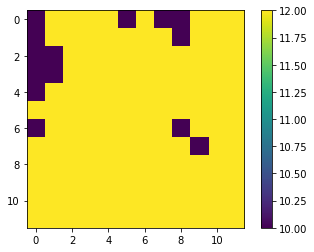

In [523]:
plt.imshow(Landcover[i_idx-r:i_idx+r,j_idx-r:j_idx+r])
plt.colorbar()

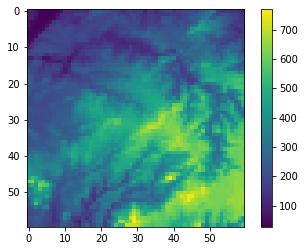

In [315]:
plt.imshow(AHI_AL[i_idx-r:i_idx+r,j_idx-r:j_idx+r])
plt.colorbar()

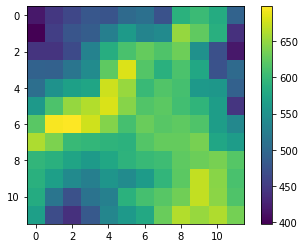

In [340]:
# i_idx,j_idx = 9470,3180 # Savannas

plt.imshow(AHI_AL[i_idx-r:i_idx+r,j_idx-r:j_idx+r][26:38,32:44])
plt.colorbar()

In [341]:
Landcover[i_idx-r:i_idx+r,j_idx-r:j_idx+r][26:38,32:44]

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], dtype=uint8)

# MAIN FUNCTION

In [5]:
total_day = 5
kvol = np.array([])
# kgeo_RJN = []
kgeo_LSR = np.array([])
kgeo_MaxMin = np.array([])
# kgeo_LSD = []
kgeo_fitting = np.array( [])
Ref = np.array([])
# time_list = []
MASK = np.array([])
Ref_B1 = np.array([])
Ref_B2 = np.array([])
Ref_B3 = np.array([])
Ref_B4 = np.array([])
Ref_B5 = np.array([])
Ref_B6 = np.array([])

# r = 30
d_count = 1
for d in range(21,26):

    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 08:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    kvol_day = np.array([])
    kgeo_day_RJN = np.array([])
    kgeo_day_LSR = np.array([])
    kgeo_day_MaxMin = np.array([])
    Ref_day_B1 = np.array([])
    Ref_day_B2 = np.array([])
    Ref_day_B3 = np.array([])
    Ref_day_B4 = np.array([])
    Ref_day_B5 = np.array([])
    Ref_day_B6 = np.array([])
    cm_day = np.array([])
    # time_list = []
    print(d)
    count = 1
    
    while date_time_now <= date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        
        if os.path.exists('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date)):
            # print(u'1当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
            fp = open('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date),'rb')
            cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(6000,6000)
            fp.close()
            cloudmask = cv2.resize(np.array(cloudmask,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)
            # print(u'2当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
            c_o_mask = Ocean_mask + cloudmask
            c_o_mask_1 = np.where(c_o_mask==2,1,0).astype(bool)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
            del cloudmask,c_o_mask
            # print(u'3当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
        else :

            c_o_mask_1 = np.full((2*r,2*r),0).astype(bool)
            
        
        cm_day = np.append(cm_day,c_o_mask_1).reshape(count,2*r,2*r)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        SZA_1 = SZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        SAA_1 = SAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        del SZA,SAA,RAA
        

        if os.path.exists(SR_PATH + '{}_AC/{}_b01.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b01.dat'.format(date,date),'rb')
            SR_B1 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
            fp.close()
        else:
            SR_B1 = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
            
        if os.path.exists(SR_PATH + '{}_AC/{}_b02.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b02.dat'.format(date,date),'rb')
            SR_B2 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
            fp.close()
        else:
            SR_B2 = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

        if os.path.exists(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date),'rb')
            SR_B3 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
            fp.close()
        else:
            SR_B3 = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

        if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb')
            SR_B4 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
            fp.close()
        else:
            SR_B4 = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

        if os.path.exists(SR_PATH + '{}_AC/{}_b05.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b05.dat'.format(date,date),'rb')
            SR = np.frombuffer(fp.read(),dtype='int16').reshape(6000,6000) / 10000
            SR_B5 = cv2.resize(np.array(SR,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
            fp.close()
        else:
            SR_B5 = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]         

        if os.path.exists(SR_PATH + '{}_AC/{}_b06.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b06.dat'.format(date,date),'rb')
            SR = np.frombuffer(fp.read(),dtype='int16').reshape(6000,6000) / 10000
            SR_B6 = cv2.resize(np.array(SR,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
            fp.close()
        else:
            SR_B6 = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
     
        kgeo_day_LSR = np.append(kgeo_day_LSR,LSR(SZA_1,VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r],RAA_1)).reshape(count,2*r,2*r)
        kgeo_day_MaxMin = np.append(kgeo_day_MaxMin,LSR_MaxMin(SZA_1,VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r],RAA_1)).reshape(count,2*r,2*r)
        kvol_day = np.append(kvol_day,RTK(SZA_1,VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r],RAA_1)).reshape(count,2*r,2*r)
        Ref_day_B1 = np.append(Ref_day_B1,SR_B1).reshape(count,2*r,2*r)
        Ref_day_B2 = np.append(Ref_day_B2,SR_B2).reshape(count,2*r,2*r)
        Ref_day_B3 = np.append(Ref_day_B3,SR_B3).reshape(count,2*r,2*r)
        Ref_day_B4 = np.append(Ref_day_B4,SR_B4).reshape(count,2*r,2*r)
        Ref_day_B5 = np.append(Ref_day_B5,SR_B5).reshape(count,2*r,2*r)
        Ref_day_B6 = np.append(Ref_day_B6,SR_B6).reshape(count,2*r,2*r)
           
        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
        
        
    MASK = np.append(MASK,cm_day).reshape(d_count,49,2*r,2*r)
    Ref_B1 = np.append(Ref_B1,Ref_day_B1).reshape(d_count,49,2*r,2*r)
    Ref_B2 = np.append(Ref_B2,Ref_day_B2).reshape(d_count,49,2*r,2*r)
    Ref_B3 = np.append(Ref_B3,Ref_day_B3).reshape(d_count,49,2*r,2*r)
    Ref_B4 = np.append(Ref_B4,Ref_day_B4).reshape(d_count,49,2*r,2*r)
    Ref_B5 = np.append(Ref_B5,Ref_day_B5).reshape(d_count,49,2*r,2*r)
    Ref_B6 = np.append(Ref_B6,Ref_day_B6).reshape(d_count,49,2*r,2*r)

    Kresult = Parallel(n_jobs=20)(delayed(get_new_kgeo)(i,j) for i in range(2*r) for j in range(2*r)) # Fitting
    kgeo_fitting = np.append(kgeo_fitting,np.array(Kresult).T.reshape(49,2*r,2*r)).reshape(d_count,49,2*r,2*r)
    kgeo_MaxMin = np.append(kgeo_MaxMin,kgeo_day_MaxMin).reshape(d_count,49,2*r,2*r)
    kgeo_LSR = np.append(kgeo_LSR,kgeo_day_LSR).reshape(d_count,49,2*r,2*r)
    kvol = np.append(kvol,kvol_day).reshape(d_count,49,2*r,2*r)
    d_count += 1
    
    
    
kgeo_fitting_cm = ma.array(np.array(kgeo_fitting),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
kgeo_MaxMin_cm = ma.array(np.array(kgeo_MaxMin),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
# kgeo_RJN_cm = ma.array(np.array(kgeo_RJN),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,10,10)
kgeo_LSR_cm = ma.array(np.array(kgeo_LSR),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
kvol_cm = ma.array(np.array(kvol),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)

Ref_cm_B1 = ma.array(np.array(Ref_B1),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
Ref_cm_B2 = ma.array(np.array(Ref_B2),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
Ref_cm_B3 = ma.array(np.array(Ref_B3),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
Ref_cm_B4 = ma.array(np.array(Ref_B4),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
Ref_cm_B5 = ma.array(np.array(Ref_B5),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)
Ref_cm_B6 = ma.array(np.array(Ref_B6),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(total_day*49,2*r,2*r)

21


<ipython-input-2-a1e714db3bfe>:209: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


22
23
24
25


In [22]:
Ref_cm_B1.shape

(245, 12, 12)

In [150]:
# Get Label
date_start = '2018-01-01 08:00'
date_end = '2018-01-01 16:00'
date_t = dt.timedelta(minutes=10)
# date_t = dt.timedelta(minutes=30)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
label = []
while date_time_now <= date_e:
    # print(date_time_now)
    start_time = T.time()
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
    label.append(HH+MIN)
    date_time_now = date_time_now + date_t

(-4.0, 1.0)

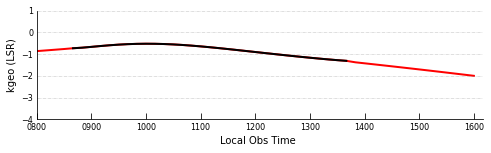

In [621]:

axis_min = -4
axis_max = 1
# r = 5
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=0,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=6,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

ax1.plot(label,kgeo_LSR[0,:,5,5],color = 'k',marker="o",markersize=0,linewidth=2,zorder=3,label='original method')
ax1.plot(label,np.array(kgeo_fitting)[0,:,5,5],color = 'red',marker="o",markersize=0,linewidth=2,zorder=0,label='Non linear fiting')
# ax1.plot(label,np.array(kgeo_MaxMin)[0,:,5,5],color = 'darkgreen',marker="o",markersize=0,linewidth=2,zorder=1,label='Previous')


# ax1.set_xticks(np.linspace(0,105,106))
# ax1.set_yticks(np.arange(axis_min,1.1,1))
ax1.set_xticks(np.arange(0,56,6))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("kgeo (LSR)",fontsize=10)
plt.grid(color='gray', axis='y',linestyle='-.', linewidth=0.5,alpha=0.5)
ax1.set_xlim(0,49)
ax1.set_ylim(axis_min,axis_max)
# fig.legend(bbox_to_anchor=(0.9, 0.9),ncol=3)
# fig.savefig('{}_{}_{}_Kernel_08_16.jpg'.format(i_idx,j_idx,MM),dpi = 1000,bbox_inches = 'tight')

(-0.2, 0.6)

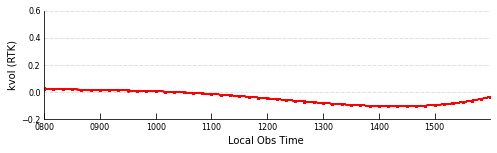

In [1046]:


axis_min = -0.2
axis_max = 0.6
r = 5
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=0,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=6,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# ax1.plot(label,np.array(kvol)[:,i_idx,j_idx],color = 'r',marker="o",markersize=1,linewidth=1,label='Ref')


for i in range(2*r):
    for j in range(2*r):
        ax1.plot(label,np.array(kvol)[0,:,i,j],color = 'r',marker="o",markersize=1,linewidth=1)



# ax1.set_xticks(np.linspace(0,105,106))
# ax1.set_yticks(np.arange(axis_min,1.1,1))
ax1.set_xticks(np.arange(0,43,6))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("kvol (RTK)",fontsize=10)
plt.grid(color='gray', axis='y',linestyle='-.', linewidth=0.5,alpha=0.5)

ax1.set_xlim(0,48)
ax1.set_ylim(axis_min,axis_max)
# plt.legend()

#  LSR Range

<ipython-input-2-a1e714db3bfe>:209: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)
<ipython-input-184-8b3bad0b4676>:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = axes.pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')


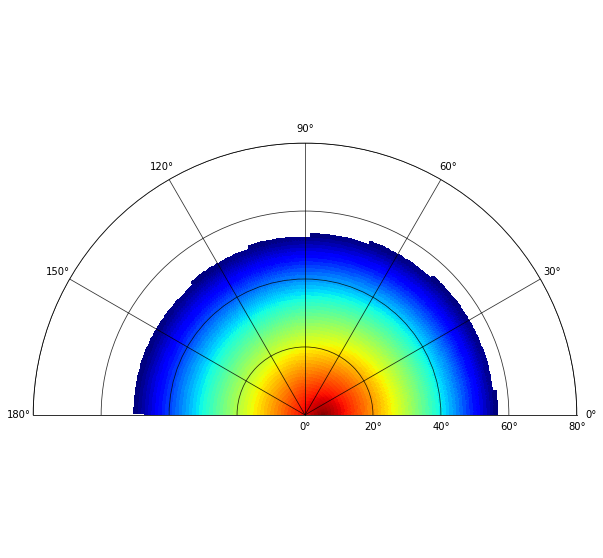

In [184]:
sza_test = np.arange(0,80,1)
vza_test = np.arange(5,76,10)
raa_test = np.arange(0,180,1)
r, theta = np.meshgrid(sza_test, raa_test)

fig,axes = plt.subplots(1,1,figsize=(20, 10),subplot_kw=dict(projection="polar"))

re = []
for k in range(180):
    c = LSR(sza_test,5,raa_test[k])
    re.append(c)
axes.set_theta_offset(0)
#设置极坐标系的起始角度为90°
axes.set_theta_direction(1)
axes.set_thetagrids(np.arange(0.0, 181.0, 30.0))
axes.set_thetamin(0.0)  
axes.set_thetamax(180.0)
axes.set_rgrids(np.arange(0, 81, 20))
axes.set_rlabel_position(np.pi/2)
axes.set_rlim(0, 80)
axes.set_yticklabels(['0°', '20°', '40°', '60°', '80°'])
# ax.set_axisbelow('True')
im = axes.pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')
axes.grid(linestyle="-", color="k", linewidth=0.8,alpha=0.8)


<ipython-input-2-a1e714db3bfe>:209: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)
<ipython-input-201-ddc5748deb74>:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axes.pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')


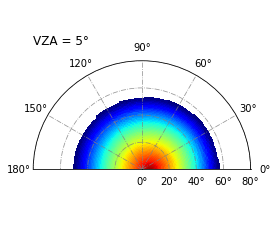

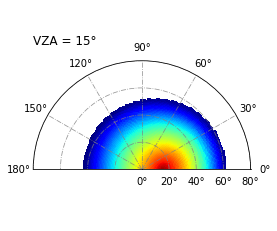

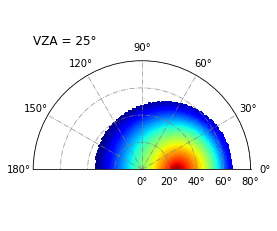

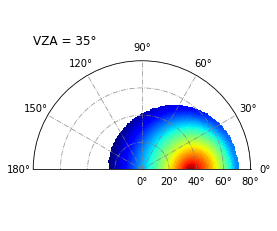

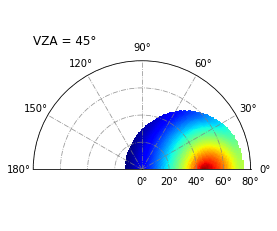

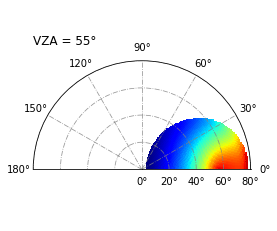

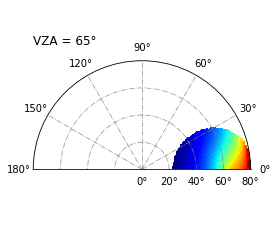

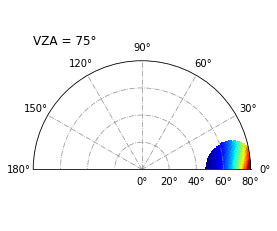

IndexError: index 8 is out of bounds for axis 0 with size 8

In [201]:
sza_test = np.arange(0,80,1)
vza_test = np.arange(5,76,10)
raa_test = np.arange(0,180,1)
r, theta = np.meshgrid(sza_test, raa_test)
for i in range(3):
    for j in range(3):
        re = []
        for k in range(180):
            c = LSR(sza_test,vza_test[(i*3)+j],raa_test[k])
            re.append(c)
        fig,axes = plt.subplots(1,1,figsize=(4, 4),subplot_kw=dict(projection="polar"))
        axes.set_theta_offset(0)
        #设置极坐标系的起始角度为90°
        axes.set_theta_direction(1)
        axes.set_thetagrids(np.arange(0.0, 181.0, 30.0))
        # axes.set_thetalabels(fontsize=15)
        axes.set_thetamin(0.0)  
        axes.set_thetamax(180.0)
        axes.set_rgrids(np.arange(0, 81, 20))
        axes.set_rlabel_position(np.pi/2)
        axes.set_rlim(0, 80)
        axes.set_yticklabels(['0°', '20°', '40°', '60°', '80°'],fontsize=15)
        # axes.set_ylabel('SZA',fontsize=15)
        # ax.set_axisbelow('True')
        axes.pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')
        axes.grid(linestyle="-.", color="gray", linewidth=0.8,alpha=0.8)
        axes.set_title('VZA = {}°'.format(vza_test[(i*3)+j]),loc='left',y=0.8,fontsize=12)
        fig.savefig('LSR_Kernel_range_{}.png'.format(vza_test[(i*3)+j]),transparent = True,dpi = 1000,bbox_inches = 'tight')

# cbar_ax = fig.add_axes() 
# plt.colorbar(sc, cax=cbar_ax)
    # fig.delaxes(axes[-1][-1])
    # fig.colorbar(im, ax=[axes[0,0],axes[0,1], axes[0,2], axes[1,0],axes[1,1], axes[1,2], axes[2,0], axes[2,1]], fraction=0.025, pad=0.03)
    # fig.savefig('LSR_Kernel_range.png',transparent = True,dpi = 1000,bbox_inches = 'tight')
    # plt.tight_layout()
        plt.show()

<ipython-input-2-a1e714db3bfe>:209: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)
<ipython-input-186-f95a6d1b2419>:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axes[i,j].pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')


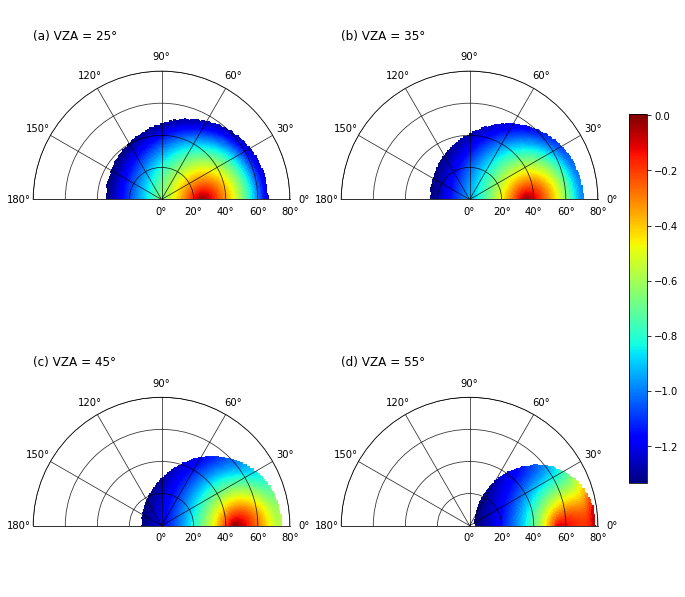

In [186]:
sza_test = np.arange(0,80,1)
vza_test = np.arange(25,56,10)
raa_test = np.arange(0,180,1)
# _RAA_Input = [(AHI_RAA_25_Summer,AHI_RAA_25_Winter),(AHI_RAA_35_Summer,AHI_RAA_35_Winter),(AHI_RAA_45_Summer,AHI_RAA_45_Winter),(AHI_RAA_55_Summer,AHI_RAA_55_Winter)]
# _SZA_Input = [(AHI_SZA_25_Summer,AHI_SZA_25_Winter),(AHI_SZA_35_Summer,AHI_SZA_35_Winter),(AHI_SZA_45_Summer,AHI_SZA_45_Winter),(AHI_SZA_55_Summer,AHI_SZA_55_Winter)]
sub_title = ['20.1°S,130.1°E','26.98°S,129.7°E','32.9°S,119.2°E','43.55°N,124.31°E']
r, theta = np.meshgrid(sza_test, raa_test)
fig,axes = plt.subplots(2,2,figsize=(11, 11),subplot_kw=dict(projection="polar"))
for i in range(2):
    for j in range(2):
        re = []
        for k in range(180):
            c = LSR(sza_test,vza_test[(i*2)+j],raa_test[k])
            re.append(c)
        axes[i,j].set_theta_offset(0)
        #设置极坐标系的起始角度为90°
        axes[i,j].set_theta_direction(1)
        axes[i,j].set_thetagrids(np.arange(0.0, 181.0, 30.0))
        axes[i,j].set_thetamin(0.0)  
        axes[i,j].set_thetamax(180.0)
        axes[i,j].set_rgrids(np.arange(0, 81, 20))
        axes[i,j].set_rlabel_position(np.pi/2)
        axes[i,j].set_rlim(0, 80)
        axes[i,j].set_yticklabels(['0°', '20°', '40°', '60°', '80°'])
        # ax.set_axisbelow('True')
        axes[i,j].pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')
        axes[i,j].grid(linestyle="-", color="k", linewidth=0.8,alpha=0.8)
        axes[i,j].set_title('({}) VZA = {}°'.format(chr(ord('a')+(i*2)+j),vza_test[(i*2)+j]),loc='left',y=0.85)
        # axes[i,j].scatter(np.radians(_RAA_Input[(i*2)+j][0]),_SZA_Input[(i*2)+j][0].reshape(-1), marker='o',c='none',edgecolors='red',lw=0.4,label='Summer')
        # axes[i,j].scatter(np.radians(_RAA_Input[(i*2)+j][1]),_SZA_Input[(i*2)+j][1].reshape(-1), marker='o',c='none',edgecolors='b',lw=0.4,label='Winter')
        
# cbar_ax = fig.add_axes() 
# plt.colorbar(sc, cax=cbar_ax)
# fig.colorbar(im, ax=[axes[0,0],axes[0,1], axes[1,0],axes[1,1]], fraction=0.025, pad=0.04)
cbar = fig.colorbar(im, ax=axes,fraction=0.03)
lines, labels = axes[1,1].get_legend_handles_labels()
# fig.legend(lines, labels, bbox_to_anchor=(0.58, 0.18),ncol=2)

plt.show()

# Multiple linear regression

In [8]:
import time
def fitting(ref,dg,dv,i,j):
    r = ref[:,i,j].reshape(-1,1)
    cm = ~np.isnan(r)
    r = r[cm].reshape(-1,1)
    kv = dv[:,i,j].reshape(-1,1)[cm].reshape(-1,1)
    kg = dg[:,i,j].reshape(-1,1)[cm].reshape(-1,1)

    # 检查是否存在空值，并去除
    if not (np.isnan(kg) | np.isnan(kv)).any():
        k = np.hstack((kv, kg))
    else:
        return np.nan, np.nan, np.nan

    # 检查数据量是否大于40
    if r.size > 40:
        linreg = LinearRegression()
        model = linreg.fit(k, r)
        fi = linreg.intercept_[0]
        fv, fg = linreg.coef_[0]
        return fi, fv, fg
    else:
        return np.nan, np.nan, np.nan

In [622]:
S = time.time()
# r = 6
total_day = 5
# B1
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B1,kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting_B1 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting_B1 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting_B1 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_Fitting_B1 = np.array(Ref_cm_B1).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_Fitting_B1 = fiso_fitting_B1 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_fitting_B1 + np.array(kgeo_fitting).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_fitting_B1

# B2
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B2,kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting_B2 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting_B2 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting_B2 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_Fitting_B2 = np.array(Ref_cm_B2).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_Fitting_B2 = fiso_fitting_B2 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_fitting_B2 + np.array(kgeo_fitting).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_fitting_B2

# B3
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B3,kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting_B3 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting_B3 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting_B3 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_Fitting_B3 = np.array(Ref_cm_B3).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_Fitting_B3 = fiso_fitting_B3 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_fitting_B3 + np.array(kgeo_fitting).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_fitting_B3

# B04
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B4,kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting_B4 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting_B4 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting_B4 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_Fitting_B4 = np.array(Ref_cm_B4).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_Fitting_B4 = fiso_fitting_B4 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_fitting_B4 + np.array(kgeo_fitting).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_fitting_B4

# B05
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B5,kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting_B5 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting_B5 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting_B5 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_Fitting_B5 = np.array(Ref_cm_B5).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_Fitting_B5 = fiso_fitting_B5 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_fitting_B5 + np.array(kgeo_fitting).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_fitting_B5

# B06
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B6,kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting_B6 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting_B6 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting_B6 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_Fitting_B6 = np.array(Ref_cm_B6).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_Fitting_B6 = fiso_fitting_B6 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_fitting_B6 + np.array(kgeo_fitting).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_fitting_B6

E = time.time()
print(E-S)

12.430745840072632


In [459]:
fiso_fitting_B6

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [623]:
S = time.time()
# r = 50
# B1
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B1,kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin_B1 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin_B1 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin_B1 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_MaxMin_B1 = np.array(Ref_cm_B1).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_MaxMin_B1 = fiso_MaxMin_B1 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_MaxMin_B1 + np.array(kgeo_MaxMin).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_MaxMin_B1

# B2
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B2,kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin_B2 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin_B2 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin_B2 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_MaxMin_B2 = np.array(Ref_cm_B2).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_MaxMin_B2 = fiso_MaxMin_B2 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_MaxMin_B2 + np.array(kgeo_MaxMin).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_MaxMin_B2

# B3
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B3,kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin_B3 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin_B3 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin_B3 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_MaxMin_B3 = np.array(Ref_cm_B3).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_MaxMin_B3 = fiso_MaxMin_B3 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_MaxMin_B3 + np.array(kgeo_MaxMin).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_MaxMin_B3

# B4
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B4,kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin_B4 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin_B4 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin_B4 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_MaxMin_B4 = np.array(Ref_cm_B4).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_MaxMin_B4 = fiso_MaxMin_B4 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_MaxMin_B4 + np.array(kgeo_MaxMin).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_MaxMin_B4

# B5
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B5,kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin_B5 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin_B5 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin_B5 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_MaxMin_B5 = np.array(Ref_cm_B5).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_MaxMin_B5 = fiso_MaxMin_B5 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_MaxMin_B5 + np.array(kgeo_MaxMin).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_MaxMin_B5

# B6
RESULT = Parallel(n_jobs=15)(delayed(fitting)(Ref_cm_B6,kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin_B6 = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin_B6 = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin_B6 = np.array(RESULT)[:,2].reshape(2*r,2*r)
X_MaxMin_B6 = np.array(Ref_cm_B6).reshape(total_day*49,2*r,2*r)[:,:,:]
Y_MaxMin_B6 = fiso_MaxMin_B6 + np.array(kvol).reshape(total_day*49,2*r,2*r)[:,:,:]*fvol_MaxMin_B6 + np.array(kgeo_MaxMin).reshape(total_day*49,2*r,2*r)[:,:,:]*fgeo_MaxMin_B6

E = time.time()
print(E-S)

1.3573510646820068


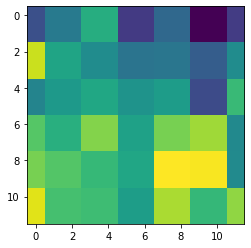

In [457]:
plt.imshow(fiso_fitting_B5)

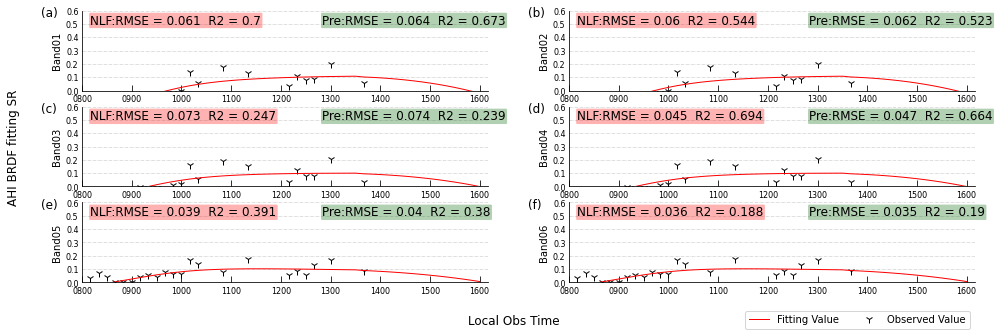

In [614]:
axis_min = 0
axis_max = 0.6
k,m = 6,6
d = 1
# r = 50
sub_title = ['20.1°S,130.1°E','26.98°S,129.7°E','32.9°S,119.2°E','43.55°N,124.31°E']

Y_MaxMin = [Y_MaxMin_B1,Y_MaxMin_B2,Y_MaxMin_B3,Y_MaxMin_B4,Y_MaxMin_B5,Y_MaxMin_B6]
Y_Fitting = [Y_Fitting_B1,Y_Fitting_B2,Y_Fitting_B3,Y_Fitting_B4,Y_Fitting_B5,Y_Fitting_B6]
X_Fitting = [X_Fitting_B1,X_Fitting_B2,X_Fitting_B3,X_Fitting_B4,X_Fitting_B5,X_Fitting_B6]

fig,axes = plt.subplots(3,2,figsize=(16, 5))
for i in range(3):
    for j in range(2):
        axes[i,j].tick_params(axis="y",which='major',length=0,direction='in',labelsize=8)
        axes[i,j].tick_params(axis="x",which='major',length=6,direction='in',labelsize=8)
        
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none') 
        
        
        X = X_Fitting[(i)*2 + j].reshape(total_day,49,2*r,2*r)[:,:,:,:]
        Y1 = Y_Fitting[(i)*2 + j].reshape(total_day,49,2*r,2*r)[:,:,:,:]
        Y2 = Y_MaxMin[(i)*2 + j].reshape(total_day,49,2*r,2*r)[:,:,:,:]
        
        nan_mask = ~np.isnan(X.reshape(-1))
        X1 = X.reshape(-1)[nan_mask]
        Y1 = Y1.reshape(-1)[nan_mask]
        nan_mask = ~np.isnan(Y1.reshape(-1))
        X1 = X1.reshape(-1)[nan_mask]
        Y1 = Y1.reshape(-1)[nan_mask]
        
        nan_mask = ~np.isnan(X.reshape(-1))
        X2 = X.reshape(-1)[nan_mask]
        Y2 = Y2.reshape(-1)[nan_mask]
        nan_mask = ~np.isnan(Y2.reshape(-1))
        X2 = X2.reshape(-1)[nan_mask]
        Y2 = Y2.reshape(-1)[nan_mask]
        
        rmse_fitting = np.sqrt(mean_squared_error(X1 ,Y1))
        r2_fitting = r2_score(X1,Y1)
        rmse_MaxMin = np.sqrt(mean_squared_error(X2 ,Y2))
        r2_MaxMin = r2_score(X2,Y2)
        
        rmse_fitting = round(rmse_fitting.astype('float64'),3)
        r2_fitting = round(r2_fitting.astype('float64'),3)
        rmse_MaxMin = round(rmse_MaxMin.astype('float64'),3)
        r2_MaxMin = round(r2_MaxMin.astype('float64'),3)

        
        # axes[i,j].plot(label,Y_MaxMin[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='darkgreen',marker="*",markersize=0,linewidth=1,label='Previous',zorder=1)
        axes[i,j].plot(label,Y_Fitting[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='red',marker="o",markersize=0,linewidth=1,label='Fitting Value',zorder=2)        
        axes[i,j].plot(label,X_Fitting[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='k',marker="1",markersize=8,linewidth=0,label='Observed Value',zorder=0)
        # for d in range(1,3):
        #     axes[i,j].plot(label,Y_MaxMin[(i)*2 + j].reshape(5,49,2*r,2*r)[d,:,k,m],c='darkgreen',marker="*",markersize=0,linewidth=1,label='Previous' if d==0 else "",zorder=1)
        #     axes[i,j].plot(label,Y_Fitting[(i)*2 + j].reshape(5,49,2*r,2*r)[d,:,k,m],c='red',marker="o",markersize=0,linewidth=1,label='Non linear fiting' if d==0 else "",zorder=2)        
        #     axes[i,j].plot(label,X_Fitting[(i)*2 + j].reshape(5,49,2*r,2*r)[d,:,k,m],c='k',marker="1",markersize=8,linewidth=0,label='Observed Value' if d==0 else "",zorder=0)

        axes[i,j].set_xticks(np.arange(0,49,6))
        axes[i,j].set_yticks(np.arange(axis_min,1.1,0.1))

        # axes[i].set_xlabel("Local Obs Time ",fontsize=10)
        axes[i,j].set_ylabel("Band0{}".format(str((i*2)+j+1)),fontsize=10)

        # fig.legend(bbox_to_anchor=(0.91, 0.85),ncol=3)
        text_x = axis_min + (axis_max - axis_min) * 0.07
        text_y = axis_max - (axis_max - axis_min) * 0.22
        axes[i,j].grid(color='gray', axis='y',linestyle='-.', linewidth=0.5,alpha=0.5)
        axes[i,j].set_xlim(axis_min,49)
        axes[i,j].set_ylim(axis_min,axis_max)
        axes[i,j].set_title('({})'.format(chr(ord('a')+(i*2)+j)),loc='left',y=0.85,x=-0.1)
        axes[i,j].text(1,0.5,s = 'NLF:RMSE = {}  R2 = {}'.\
                       format(rmse_fitting,r2_fitting),fontsize=12,bbox=dict(boxstyle='round,pad=0.1', fc='red', ec='none',lw=2 ,alpha=0.3))
        axes[i,j].text(29,0.5,s = 'Pre:RMSE = {}  R2 = {}'.\
                       format(rmse_MaxMin,r2_MaxMin),fontsize=12,bbox=dict(boxstyle='round,pad=0.1', fc='darkgreen', ec='none',lw=2 ,alpha=0.3))
        
        
lines, labels = axes[1,1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.9, 0.06),ncol=3)

fig.supxlabel('Local Obs Time',fontsize=12,y=0)
fig.supylabel('AHI BRDF fitting SR',fontsize=12,x=0.06)

# fig.savefig('label.jpg'.format(i_idx,j_idx,MM),dpi = 1000,bbox_inches = 'tight')
plt.show()

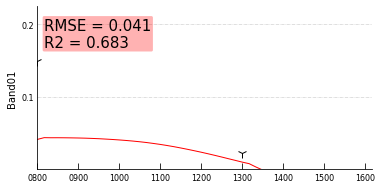

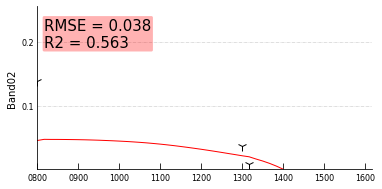

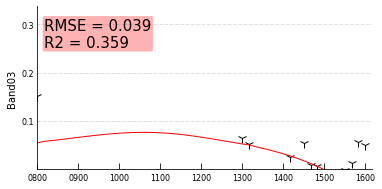

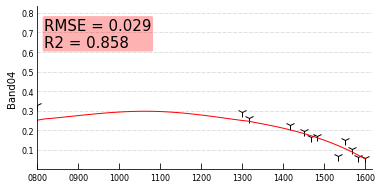

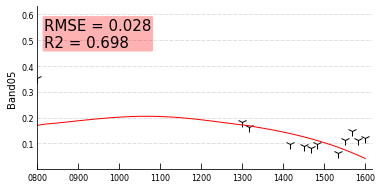

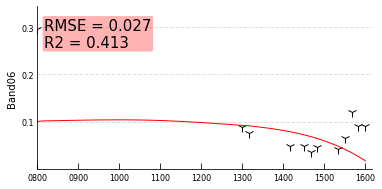

In [325]:

# k,m = 35,20
# d = 1
# r = 50
sub_title = ['20.1°S,130.1°E','26.98°S,129.7°E','32.9°S,119.2°E','43.55°N,124.31°E']

Y_MaxMin = [Y_MaxMin_B1,Y_MaxMin_B2,Y_MaxMin_B3,Y_MaxMin_B4,Y_MaxMin_B5,Y_MaxMin_B6]
Y_Fitting = [Y_Fitting_B1,Y_Fitting_B2,Y_Fitting_B3,Y_Fitting_B4,Y_Fitting_B5,Y_Fitting_B6]
X_Fitting = [X_Fitting_B1,X_Fitting_B2,X_Fitting_B3,X_Fitting_B4,X_Fitting_B5,X_Fitting_B6]


for i in range(6):
    
    fig,axes = plt.subplots(1,1,figsize=(6, 3))
    axes.tick_params(axis="y",which='major',length=0,direction='in',labelsize=8)
    axes.tick_params(axis="x",which='major',length=6,direction='in',labelsize=8)

    axes.spines['right'].set_color('none')
    axes.spines['top'].set_color('none') 
    

    X = X_Fitting[i].reshape(total_day,49,2*r,2*r)[:,:,:,:]
    Y1 = Y_Fitting[i].reshape(total_day,49,2*r,2*r)[:,:,:,:]
    Y2 = Y_MaxMin[i].reshape(total_day,49,2*r,2*r)[:,:,:,:]

    nan_mask = ~np.isnan(X.reshape(-1))
    X1 = X.reshape(-1)[nan_mask]
    Y1 = Y1.reshape(-1)[nan_mask]
    nan_mask = ~np.isnan(Y1.reshape(-1))
    X1 = X1.reshape(-1)[nan_mask]
    Y1 = Y1.reshape(-1)[nan_mask]

    nan_mask = ~np.isnan(X.reshape(-1))
    X2 = X.reshape(-1)[nan_mask]
    Y2 = Y2.reshape(-1)[nan_mask]
    nan_mask = ~np.isnan(Y2.reshape(-1))
    X2 = X2.reshape(-1)[nan_mask]
    Y2 = Y2.reshape(-1)[nan_mask]
    
    axis_min = 0
    axis_max = np.nanmax(np.nanmax(Y1)) * 2
    
    
    rmse_fitting = np.sqrt(mean_squared_error(X1 ,Y1))
    r2_fitting = r2_score(X1,Y1)
    rmse_MaxMin = np.sqrt(mean_squared_error(X2 ,Y2))
    r2_MaxMin = r2_score(X2,Y2)

    rmse_fitting = round(rmse_fitting.astype('float64'),3)
    r2_fitting = round(r2_fitting.astype('float64'),3)
    rmse_MaxMin = round(rmse_MaxMin.astype('float64'),3)
    r2_MaxMin = round(r2_MaxMin.astype('float64'),3)


    # axes.plot(label,Y_MaxMin[i].reshape(5,49,2*r,2*r)[d,:,k,m],c='darkgreen',marker="*",markersize=0,linewidth=1,label='Previous',zorder=1)
    axes.plot(label,Y_Fitting[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='red',marker="o",markersize=0,linewidth=1,label='BRDF Fitting',zorder=2)        
    axes.plot(label,X_Fitting[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='k',marker="1",markersize=10,linewidth=0,label='Observed Value',zorder=0)
    # for d in range(0,4):
    #     # axes.plot(label,Y_MaxMin[i].reshape(5,49,2*r,2*r)[d,:,k,m],c='darkgreen',marker="*",markersize=0,linewidth=1,label='Previous' if d==0 else "",zorder=1)
    #     axes.plot(label,Y_Fitting[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='red',marker="o",markersize=0,linewidth=1,label='Non linear fiting' if d==0 else "",zorder=2)        
    #     axes.plot(label,X_Fitting[i].reshape(total_day,49,2*r,2*r)[d,:,k,m],c='k',marker="1",markersize=8,linewidth=0,label='Observed Value' if d==0 else "",zorder=0)

    axes.set_xticks(np.arange(0,49,6))
    axes.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

    # axes[i].set_xlabel("Local Obs Time ",fontsize=10)
    axes.set_ylabel("Band0{}".format(str(i+1),fontsize=10))

    # fig.legend(bbox_to_anchor=(0.91, 0.85),ncol=3)
    text_x = axis_min + (axis_max - axis_min) * 0.07
    text_y = axis_max - (axis_max - axis_min) * 0.22
    axes.grid(color='gray', axis='y',linestyle='-.', linewidth=0.5,alpha=0.5)
    axes.set_xlim(axis_min,49)
    axes.set_ylim(axis_min,axis_max)
    # axes.set_title('({})'.format(chr(ord('a')+(i*2)+j)),loc='left',y=0.85,x=-0.1)
    axes.text(1,axis_max *0.75,s = 'RMSE = {}\nR2 = {}'.\
                   format(rmse_fitting,r2_fitting),fontsize=15,bbox=dict(boxstyle='round,pad=0.1', fc='red', ec='none',lw=2 ,alpha=0.3))
    # axes.text(1,axis_max*0.7,s = 'Pre :RMSE = {}  R2 = {}'.\
    #                format(rmse_MaxMin,r2_MaxMin),fontsize=12,bbox=dict(boxstyle='round,pad=0.1', fc='darkgreen', ec='none',lw=2 ,alpha=0.3))
        
    fig.savefig('{}_{}_{}_B{}_BRDF_Performance.jpg'.format(i_idx,j_idx,MM,str(i+1)),dpi = 1000,bbox_inches = 'tight')
    plt.show()
# lines, labels = axes[1,1].get_legend_handles_labels()
# fig.legend(lines, labels, bbox_to_anchor=(0.9, 0.06),ncol=3)

# fig.supxlabel('Local Obs Time',fontsize=12,y=0)
# fig.supylabel('AHI BRDF fitting SR',fontsize=12,x=0.06)
# fig.savefig('{}_{}_{}_BRDF_Performance.jpg'.format(i_idx,j_idx,MM),dpi = 1000,bbox_inches = 'tight')
# plt.show()

# Pandas

In [ ]:
import pandas as pd

In [ ]:
FISO = fiso.reshape(-1)[~np.isnan(fiso.reshape(-1))]

In [ ]:
df = pd.DataFrame(FISO)
df.describe()

,0
count,100.000000
mean,0.514242
std,0.053382
min,0.412535
25%,0.477413
50%,0.510679
75%,0.545420
max,0.659810


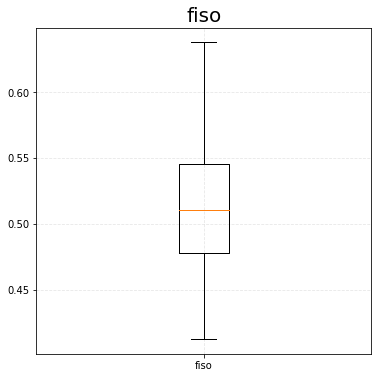

In [ ]:
FISO = fiso.reshape(-1)[~np.isnan(fiso.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FISO,showfliers = False,labels=['fiso'])
plt.title('fiso',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

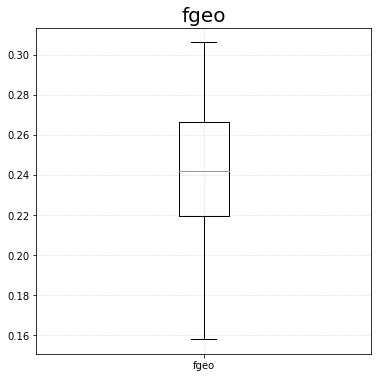

In [ ]:
FGEO = fgeo.reshape(-1)[~np.isnan(fgeo.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FGEO,showfliers = False,labels=['fgeo'])
plt.title('fgeo',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

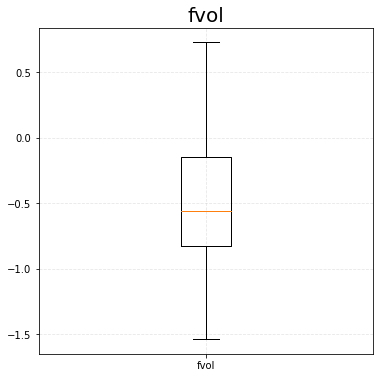

In [ ]:
FVOL = fvol.reshape(-1)[~np.isnan(fvol.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FVOL,showfliers = False,labels=['fvol'])
plt.title('fvol',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

In [ ]:
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)[1000:4000,3500:6500]

# SGLI

In [4]:
def read_SGLI(lat_idx,lon_idx):
 # 获取该经纬度的Tile号
                # print(lat_idx,lon_idx) 

    tile = lonlat2tileidx([AHI_lat[lat_idx],AHI_lon[lon_idx]])

    # print(tile) 
#                 # SGLI 文件名
    SGLI_tile_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001.h5'.format(date,tile)
    SGLI_VZA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_zenith.tif'.format(date,tile)
    SGLI_VAA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_azimuth.tif'.format(date,tile)
    SGLI_TIME_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Obs_time.tif'.format(date,tile)
    
    SGLI_REF_VN04_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_VN04.tif'.format(date,tile)
    SGLI_REF_VN05_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_VN05.tif'.format(date,tile)
    SGLI_REF_VN07_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_VN07.tif'.format(date,tile)
    SGLI_REF_VN10_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_VN10.tif'.format(date,tile)
    SGLI_REF_SW03_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_SW03.tif'.format(date,tile)
    SGLI_REF_SW04_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Rs_SW04.tif'.format(date,tile)


    # 存在SGLI文件
    # print('1')
    if os.path.exists(reporjection_file_path + SGLI_VAA_filename) and os.path.exists(reporjection_file_path + SGLI_VZA_filename) and os.path.exists(reporjection_file_path + SGLI_TIME_filename):
        # print('1')
        # 读取该像素经纬度SGLI的VZA和VAA
        SGLI_VZA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VZA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
        SGLI_VAA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VAA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])

        if not np.isnan(SGLI_VZA_PL) and not np.isnan(SGLI_VAA_PL):
            if SGLI_VAA_PL < 0:
                SGLI_VAA_PL = SGLI_VAA_PL + 360
        # 计算该像素经纬度SGLI的SZA和SAA

            SGLI_Obs_TIME = SGLI_2_AHI_TIME(reporjection_file_path + SGLI_TIME_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
            # print(SGLI_Obs_TIME.values[0])
            # print(SGLI_Obs_TIME)
            if not np.isnan(SGLI_Obs_TIME):
                # print(SGLI_Obs_TIME)
                SGLI_MIN = int(round(math.modf(SGLI_Obs_TIME)[0],3)*60)
                SGLI_HH = int(math.modf(SGLI_Obs_TIME)[1])
                if SGLI_HH <= 23 and SGLI_MIN >= 0 and SGLI_MIN <= 59:
                    SGLI_SAA_PL,SGLI_SZA_PL = SGLI_SA(SGLI_HH,SGLI_MIN,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_Ref_VN04 = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_VN04_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_Ref_VN05 = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_VN05_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_Ref_VN07 = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_VN07_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_Ref_VN10 = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_VN10_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_Ref_SW03 = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_SW03_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_Ref_SW04 = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_SW04_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    # 读取AHI的SZA、SAA
                    SGLI_RAA_PL = abs(SGLI_SAA_PL - SGLI_VAA_PL.data[0])
                    SGLI_RAA_PL = np.where(SGLI_RAA_PL>180,360-SGLI_RAA_PL,SGLI_RAA_PL)
                    
                    if not np.isnan(SGLI_Ref_VN04):
                        SGLI_Ref_VN04 = SGLI_Ref_VN04.values[0]
                    if not np.isnan(SGLI_Ref_VN05):
                        SGLI_Ref_VN05 = SGLI_Ref_VN05.values[0]
                    if not np.isnan(SGLI_Ref_VN07):
                        SGLI_Ref_VN07 = SGLI_Ref_VN07.values[0]
                    if not np.isnan(SGLI_Ref_VN10):
                        SGLI_Ref_VN10 = SGLI_Ref_VN10.values[0]
                    if not np.isnan(SGLI_Ref_SW03):
                        SGLI_Ref_SW03 = SGLI_Ref_SW03.values[0]
                    if not np.isnan(SGLI_Ref_SW04):
                        SGLI_Ref_SW04 = SGLI_Ref_SW04.values[0]
                        
                    return SGLI_VZA_PL.values[0],SGLI_SZA_PL,SGLI_RAA_PL,SGLI_SAA_PL,SGLI_VAA_PL.values[0],\
                            SGLI_Ref_VN04,SGLI_Ref_VN05,SGLI_Ref_VN07,SGLI_Ref_VN10,SGLI_Ref_SW03,SGLI_Ref_SW04

                else:
                    return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
            else:
                return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
        else:
            return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    else:
        return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan



In [20]:
r = 6
AHI_lat = np.linspace(60,-59.99,12000)[i_idx-r:i_idx+r]
AHI_lon = np.linspace(85,204.99,12000)[j_idx-r:j_idx+r]

SGLI_VZA = np.array([])
SGLI_SZA = np.array([])
SGLI_RAA = np.array([])
SGLI_VAA = np.array([])
SGLI_SAA = np.array([])
SGLI_Ref_VN04 = np.array([])
SGLI_Ref_VN05 = np.array([])
SGLI_Ref_VN07 = np.array([])
SGLI_Ref_VN10 = np.array([])
SGLI_Ref_SW03 = np.array([])
SGLI_Ref_SW04 = np.array([])


for d in range(21,26):
    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 09:00'.format(str(d))
    date_t = dt.timedelta(days=1)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    
    # time_list = []
    while date_time_now <= date_e:
        print(date_time_now)
        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split_SGLI(date_time_now)
        current_result = Parallel(n_jobs=30)(delayed(read_SGLI)(i,j) for i in range(2*r) for j in range(2*r))
        c_SGLI_VZA = np.array(current_result)[:,0].reshape(2*r,2*r)
        c_SGLI_SZA = np.array(current_result)[:,1].reshape(2*r,2*r)
        c_SGLI_RAA = np.array(current_result)[:,2].reshape(2*r,2*r)
        c_SGLI_SAA = np.array(current_result)[:,3].reshape(2*r,2*r)
        c_SGLI_VAA = np.array(current_result)[:,4].reshape(2*r,2*r)
        c_SGLI_VN04 = np.array(current_result)[:,5].reshape(2*r,2*r)
        c_SGLI_VN05 = np.array(current_result)[:,6].reshape(2*r,2*r)
        c_SGLI_VN07 = np.array(current_result)[:,7].reshape(2*r,2*r)
        c_SGLI_VN10 = np.array(current_result)[:,8].reshape(2*r,2*r)
        c_SGLI_SW03 = np.array(current_result)[:,9].reshape(2*r,2*r)
        c_SGLI_SW04= np.array(current_result)[:,10].reshape(2*r,2*r)
        
        SGLI_VZA = np.append(SGLI_VZA,c_SGLI_VZA)
        SGLI_SZA = np.append(SGLI_SZA,c_SGLI_SZA)
        SGLI_RAA = np.append(SGLI_RAA,c_SGLI_RAA)
        SGLI_SAA = np.append(SGLI_SAA,c_SGLI_SAA)
        SGLI_VAA = np.append(SGLI_VAA,c_SGLI_VAA)
        SGLI_Ref_VN04 = np.append(SGLI_Ref_VN04,c_SGLI_VN04)
        SGLI_Ref_VN05 = np.append(SGLI_Ref_VN05,c_SGLI_VN05)
        SGLI_Ref_VN07 = np.append(SGLI_Ref_VN07,c_SGLI_VN07)
        SGLI_Ref_VN10 = np.append(SGLI_Ref_VN10,c_SGLI_VN10)
        SGLI_Ref_SW03 = np.append(SGLI_Ref_SW03,c_SGLI_SW03)
        SGLI_Ref_SW04 = np.append(SGLI_Ref_SW04,c_SGLI_SW04)    
        date_time_now = date_time_now + date_t 

SGLI_VZA = SGLI_VZA.reshape(5,2*r,2*r) 
SGLI_SZA = SGLI_SZA.reshape(5,2*r,2*r)        
SGLI_SZA = SGLI_SZA.reshape(5,2*r,2*r)
SGLI_RAA = SGLI_RAA.reshape(5,2*r,2*r)
SGLI_SAA = SGLI_SAA.reshape(5,2*r,2*r)
SGLI_VAA = SGLI_VAA.reshape(5,2*r,2*r)       
SGLI_Ref_VN04 = SGLI_Ref_VN04.reshape(5,2*r,2*r)
SGLI_Ref_VN05 = SGLI_Ref_VN05.reshape(5,2*r,2*r)
SGLI_Ref_VN07 = SGLI_Ref_VN07.reshape(5,2*r,2*r)
SGLI_Ref_VN10 = SGLI_Ref_VN10.reshape(5,2*r,2*r)
SGLI_Ref_SW03 = SGLI_Ref_SW03.reshape(5,2*r,2*r)
SGLI_Ref_SW04 = SGLI_Ref_SW04.reshape(5,2*r,2*r)

2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00


In [22]:
SGLI_VAA

array([[[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
       

In [429]:
fvol_fitting_B6.shape

(60, 60)

In [79]:
def identifer(li):
    result = []
    for a in li:
        mean = np.nanmean(a)
        std = np.nanstd(a) 
        down = mean - 3 * std
        up =  mean + 3 * std
        n_a = np.where(a < down,np.nan,a)
        n_a = np.where(n_a > up,np.nan,n_a)
        result.append(n_a)
    return result

In [633]:
dlist = 0
# r = 9
SGLI_kvol = RTK(SGLI_SZA[dlist],SGLI_VZA[dlist],SGLI_RAA[dlist]).reshape(2*r,2*r)
SGLI_kgeo = LSR_MaxMin(SGLI_SZA[dlist],SGLI_VZA[dlist],SGLI_RAA[dlist]).reshape(2*r,2*r)

XX_B1 = SGLI_Ref_VN04[dlist]
YY_B1 = fiso_fitting_B1 + np.array(SGLI_kvol)*fvol_fitting_B1 + np.array(SGLI_kgeo)*fgeo_fitting_B1

XX_B2 = SGLI_Ref_VN05[dlist]
YY_B2 = fiso_fitting_B2 + np.array(SGLI_kvol)*fvol_fitting_B2 + np.array(SGLI_kgeo)*fgeo_fitting_B2

XX_B3 = SGLI_Ref_VN07[dlist]
YY_B3 = fiso_fitting_B3 + np.array(SGLI_kvol)*fvol_fitting_B3 + np.array(SGLI_kgeo)*fgeo_fitting_B3

XX_B4 = SGLI_Ref_VN10[dlist]
YY_B4 = fiso_fitting_B4 + np.array(SGLI_kvol)*fvol_fitting_B4 + np.array(SGLI_kgeo)*fgeo_fitting_B4

XX_B5 = SGLI_Ref_SW03[dlist]
YY_B5 = fiso_fitting_B5 + np.array(SGLI_kvol)*fvol_fitting_B5 + np.array(SGLI_kgeo)*fgeo_fitting_B5

XX_B6 = SGLI_Ref_SW04[dlist]
YY_B6 = fiso_fitting_B6 + np.array(SGLI_kvol)*fvol_fitting_B6 + np.array(SGLI_kgeo)*fgeo_fitting_B6


In [634]:
XX_B1

array([[0.0551, 0.0166, 0.0151, 0.0246, 0.0239, 0.033 , 0.0189, 0.0134,
        0.0196, 0.021 , 0.008 , 0.0108],
       [0.0263, 0.0332, 0.0266, 0.0183, 0.0138, 0.0167, 0.018 , 0.0141,
        0.0116, 0.0109, 0.0094, 0.0153],
       [0.0181, 0.0323, 0.021 , 0.0222, 0.0199, 0.0116, 0.0217, 0.0308,
        0.0313, 0.0128, 0.0167, 0.0071],
       [0.0377, 0.04  , 0.0076, 0.0176, 0.0131, 0.0135, 0.0229, 0.0156,
        0.0249, 0.0206, 0.0547, 0.0136],
       [0.0172, 0.0227, 0.0092, 0.0246, 0.0236, 0.0235, 0.0133, 0.0237,
        0.0535, 0.0127, 0.0023, 0.0051],
       [0.0524, 0.0296, 0.0185, 0.0275, 0.0256, 0.0229, 0.0356, 0.0153,
        0.0231, 0.015 , 0.0091, 0.0046],
       [0.0302, 0.015 , 0.0132, 0.0148, 0.0093, 0.0155, 0.0317, 0.0185,
        0.0104, 0.0121, 0.0142, 0.013 ],
       [0.032 , 0.0339, 0.0188, 0.0136, 0.012 , 0.0271, 0.0136, 0.0324,
        0.0104, 0.0091, 0.0222, 0.0155],
       [0.0373, 0.0238, 0.029 , 0.0133, 0.0271, 0.0364, 0.0256, 0.0348,
        0.0297, 0.0132, 

In [635]:
YY_B1

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.14898778, 0.12256006,
        0.14274523, 0.13751659],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.11865675, 0.1052817 ,
        0.12422243,

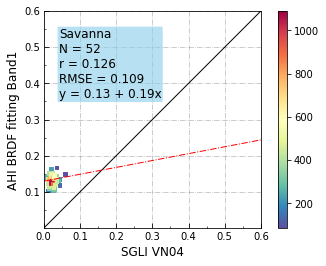

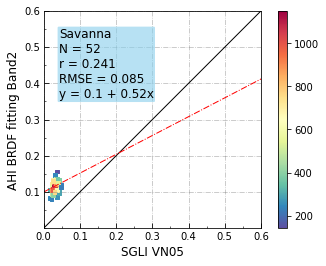

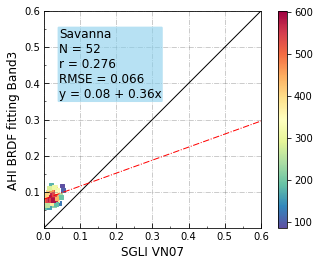

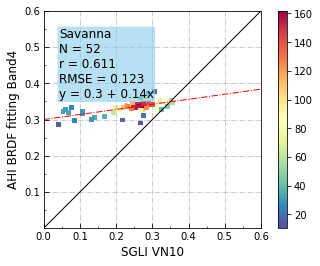

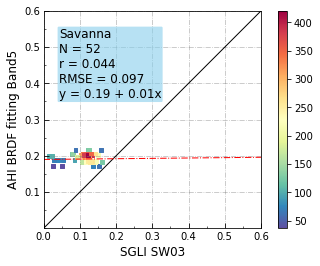

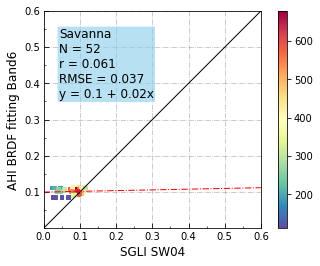

In [636]:
XX_AHI2SGLI = [XX_B1,XX_B2,XX_B3,XX_B4,XX_B5,XX_B6]
YY_SGLI = [YY_B1,YY_B2,YY_B3,YY_B4,YY_B5,YY_B6]



SGLI_band = ['VN04','VN05','VN07','VN10','SW03','SW04']
SBAF_Offset_OS = [0.008,0.006,0.002,0.0002,0.0015,0]
SBAF_Slope_OS = [0.95,0.927,0.896,0.984,0.987,1]

SBAF_Offset_Grassland = [0.0055,0.0007,0.0027,0,-0.0017,0]
SBAF_Slope_Grassland = [0.973,0.993,0.909,0.984,0.995,1]

SBAF_Offset_Cropland = [0.007,0.0005,0.0055,0.0005,0.0005,0]
SBAF_Slope_Cropland = [0.979,1,0.906,0.976,1.001,1]

SBAF_Offset_EBF = [0.0054,-0.003,0.004,0.0006,0.002,0]
SBAF_Slope_EBF = [1.042,1.071,1.007,0.964,1.019,1]

SBAF_Offset_Savanna = [0.0069,0.004,0.0053,0.0001,0.0035,0]
SBAF_Slope_Savanna = [0.973,0.962,0.880,0.977,0.985,1]

axis_min = 0.0
axis_max = 0.6
for i in range(6):
    
#     XX = ma.array(np.array(XX_AHI2SGLI[i]),mask = ~np.array(MASK[3,14,30:70,30:70]).astype(bool),fill_value = np.nan).filled().reshape(40,40) * SBAF_Slope_Savanna[i] + SBAF_Offset_Savanna[i]
#     YY = ma.array(np.array(YY_SGLI[i]),mask = ~np.array(MASK[3,14,30:70,30:70]).astype(bool),fill_value = np.nan).filled().reshape(40,40)
    
    XX = XX_AHI2SGLI[i].reshape(-1) * SBAF_Slope_Savanna[i] + SBAF_Offset_Savanna[i]
    YY = YY_SGLI[i].reshape(-1)
    nan_mask = ~np.isnan(YY.reshape(-1))
    XX = XX.reshape(-1)[nan_mask]
    YY = YY.reshape(-1)[nan_mask]


    nan_mask = ~np.isnan(XX.reshape(-1))
    XX = XX.reshape(-1)[nan_mask]
    YY = YY.reshape(-1)[nan_mask]
    XX = identifer(XX)
    YY = identifer(YY)
    rmse = np.sqrt(mean_squared_error(XX ,YY))
    p = np.polyfit(XX ,YY,1)    

    k = round(p[0],2)
    b = round(p[1],2)
    rmse = round(rmse.astype('float64'),3)

    pccs = np.corrcoef(XX, YY)[0,1]
    pccs = round(pccs.astype('float64'),3)

    x = np.arange(axis_min,axis_max+1)
    y = 1 * x

    xx = np.arange(0,1+0.1,0.05) 
    yy = k * xx + b
    
    xy = np.vstack([XX,YY])
    z = gaussian_kde(xy)(xy)
    
    fig = plt.figure(figsize=(4,4))
    ax1 = fig.add_subplot(111,aspect='equal')
    ax1.minorticks_on()
    # x_major_locator = plt.MultipleLocator(5)
    x_minor_locator = plt.MultipleLocator(0.05)
    ax1.xaxis.set_minor_locator(x_minor_locator)
    # ax.xaxis.set_major_locator(x_major_locator)
    ax1.yaxis.set_minor_locator(x_minor_locator)
    # ax.yaxis.set_major_locator(x_major_locator)

    ax1.tick_params(axis="y",which='minor',length=2,direction='in',labelsize=10)
    ax1.tick_params(axis="y",which='major',length=5,direction='in',labelsize=10)

    ax1.tick_params(axis="x",which='minor',length=2,direction='in',labelsize=10)
    ax1.tick_params(axis="x",which='major',length=5,direction='in',labelsize=10)


    # ax1.spines['right'].set_color('none')
    # ax1.spines['top'].set_color('none')


    im = ax1.scatter(XX,YY,marker='s', c=z,s=15,cmap='Spectral_r')
    # im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

    ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
    ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

    ax1.set_xlabel("SGLI {}".format(SGLI_band[i]),fontsize=12)
    ax1.set_ylabel("AHI BRDF fitting Band{}".format(str(i+1)),fontsize=12)


    ax1.plot(x,y,color='k',linewidth=1,linestyle='-',alpha=1)
    ax1.plot(xx,yy,color='r',linewidth=1,linestyle='-.') 


    text_x = axis_min + (axis_max - axis_min) * 0.07
    text_y = axis_max - (axis_max - axis_min) * 0.4
    plt.grid(color='gray',alpha=0.5,linestyle='-.')

    ax1.text(text_x,text_y,s = 'Savanna\nN = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),pccs,rmse,b,k),fontsize=12,bbox=dict(boxstyle='round,pad=0.1', fc='skyblue', ec='none',lw=2 ,alpha=0.6))
    ax1.set_xlim(axis_min,axis_max)
    ax1.set_ylim(axis_min,axis_max)
    # ax1.text(0.52,0.1,s = 'Open Shrubland\nAustralia\n{}/{}/21'.format(YYYY,MM),fontsize=10)

    cax = add_right_cax(ax1, pad=0.06, width=0.03)
    cb = plt.colorbar(im,cax=cax)
    # cb.ax.set_xlabel('Count',rotation=360)
    # plt.title('2018/07/26')
 
    fig.savefig('{}_{}_{}_B{}_12.jpg'.format(i_idx,j_idx,MM,str(i+1)),dpi = 1000,bbox_inches = 'tight')
    plt.show()

# MISR

In [ ]:
MISR_Ref = np.array([[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, 0.42162606, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, 0.44482085, 0.40644264, 0.40644264, 0.3562382, 0.35143137, -0.1, -0.1, -0.1], [-0.1, -0.1, 0.47709516, 0.38515535, 0.3885125, 0.3885125, 0.35967162, -0.1, -0.1, -0.1], [-0.1, 0.43329975, 0.43329975, 0.44978026, 0.3927852, 0.3927852, 0.4154459, -0.1, -0.1, -0.1], [0.5289782, -0.1, -0.1, 0.3878258, 0.34860831, 0.37500763, 0.37500763, -0.1, -0.1, -0.1]])
MISR_Ref = np.where(MISR_Ref==-0.1,np.nan,MISR_Ref)

In [ ]:
MISR_VAA = np.full((10,10),109.05)
MISR_VZA = np.full((10,10),1.41)

In [ ]:
def MISR_SA(y,m,d,h,_min,lat,lon):

    dt = datetime.datetime(y,m,d,h,_min)
    
    SAA,SZA = calc_sunpos(dt,lat,lon)
    return SAA,SZA
MISR_SAA,MISR_SZA = [],[]
for lat_idx in range(10):
    for lon_idx in range(10):
        a = MISR_SA(2018,7,30,1,26,AHI_lat[lat_idx],AHI_lon[lon_idx])
        MISR_SAA.append(a[0])
        MISR_SZA.append(a[1])
MISR_SAA = np.array(MISR_SAA).reshape(10,10)
MISR_SZA = np.array(MISR_SZA).reshape(10,10)


In [ ]:
MISR_RAA = MISR_SAA - MISR_VAA

In [ ]:
MISR_RAA

array([[36.12464628, 36.14258236, 36.16053209, 36.17846817, 36.19641791,
        36.21436765, 36.23233104, 36.25029444, 36.26825784, 36.2862349 ],
       [36.11407315, 36.13200922, 36.1499453 , 36.16789504, 36.18584478,
        36.20380817, 36.22175791, 36.23973497, 36.25769837, 36.27567542],
       [36.10347269, 36.12142243, 36.13935851, 36.15730824, 36.17527164,
        36.19322138, 36.21118478, 36.22916183, 36.24712523, 36.26510229],
       [36.0928859 , 36.11082198, 36.12877171, 36.14672145, 36.16468485,
        36.18264825, 36.20061164, 36.21857504, 36.2365521 , 36.25452916],
       [36.08227179, 36.10022152, 36.11817126, 36.13613466, 36.1540844 ,
        36.17206145, 36.19002485, 36.20800191, 36.22597897, 36.24395602],
       [36.07167133, 36.08962107, 36.10757081, 36.1255342 , 36.1434976 ,
        36.161461  , 36.17943806, 36.19740146, 36.21539217, 36.23336923],
       [36.06104356, 36.07900696, 36.09695669, 36.11492009, 36.13288349,
        36.15086055, 36.1688376 , 36.18681466

In [ ]:
MISR_kvol = RTK(MISR_SZA,MISR_VZA,MISR_RAA).reshape(10,10)
MISR_kgeo = LSR(MISR_SZA,MISR_VZA,MISR_RAA).reshape(10,10)
Y_MISR = fiso + np.array(MISR_kvol)[:,:]*fvol + np.array(MISR_kgeo)[:,:]*fgeo

(0.3, 0.8)

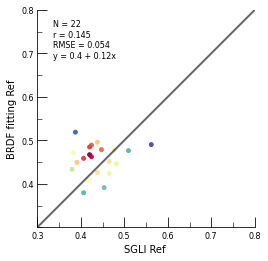

In [ ]:

# XX = np.array(XX).reshape(-1) + 0.1603
# YY = np.array(YY).reshape(-1)

# XX = SGLI_Ref[d_idx].reshape(-1) * 0.989 + 0.1021 # EBF
XX = MISR_Ref.reshape(-1)*1.01 + 0.02776 # Croplands
YY = Y_MISR.reshape(-1)

nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]


nan_mask = ~np.isnan(XX.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]

rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

pccs = np.corrcoef(XX, YY)[0,1]
r = round(pccs.astype('float64'),3)

axis_min = 0.3
axis_max = 0.8
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
XX, YY, z = XX[idx], YY[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(XX,YY,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("SGLI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
# ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),r,rmse,b,k),fontsize=8)
# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
# plt.title('2018/07/26')
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

In [ ]:
import pandas as pd
data = pd.DataFrame({'SGLI':XX, 
                     'AHI':YY})

In [ ]:
data.corr()

,SGLI,AHI
SGLI,1.000000,0.116162
AHI,0.116162,1.000000


In [ ]:
data.corr('kendall')

,SGLI,AHI
SGLI,1.000000,0.048495
AHI,0.048495,1.000000


In [ ]:
data.corr('spearman')

,SGLI,AHI
SGLI,1.00000,0.07325
AHI,0.07325,1.00000


# MCD43

In [214]:
from suncalc import get_position, get_times

In [215]:
class AHI_angle:
    def __init__(self,date):
        self.date = date        
    def read_angle_data(self):
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)
        
        AHI_SZA_File = open(SZA_PATH + sza_file_name,'rb')
        AHI_SZA = np.frombuffer(AHI_SZA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SZA_File.close()
        AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)
        
        
        AHI_SAA_File = open(SAA_PATH + saa_file_name,'rb')
        AHI_SAA = np.frombuffer(AHI_SAA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SAA_File.close()
        AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)
        
        return AHI_SZA,AHI_SAA

SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

In [314]:
with open('/data01/people/liwei/Data/MCD43A4_AHI/MCD43A1_20180122_Band2_fiso.dat','rb') as fp:
    MCD43_fiso = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.001
    
with open('/data01/people/liwei/Data/MCD43A4_AHI/MCD43A1_20180122_Band2_fvol.dat','rb') as fp:
    MCD43_fvol = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.001
    
with open('/data01/people/liwei/Data/MCD43A4_AHI/MCD43A1_20180122_Band2_fgeo.dat','rb') as fp:
    MCD43_fgeo = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.001
    
r = 25

MCD43_fiso = np.where(MCD43_fiso==3.2767,np.nan,MCD43_fiso)
MCD43_fvol = np.where(MCD43_fvol==3.2767,np.nan,MCD43_fvol)
MCD43_fgeo = np.where(MCD43_fgeo==3.2767,np.nan,MCD43_fgeo)

MCD43_fiso = MCD43_fiso[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
MCD43_fvol = MCD43_fvol[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
MCD43_fgeo = MCD43_fgeo[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

In [218]:
MCD43_fgeo

array([[0.023, 0.039, 0.044, ..., 0.031, 0.016, 0.019],
       [0.021, 0.016, 0.035, ..., 0.023, 0.023, 0.021],
       [0.016, 0.013, 0.031, ..., 0.023, 0.022, 0.019],
       ...,
       [0.016, 0.016, 0.03 , ..., 0.035, 0.036, 0.014],
       [0.015, 0.012, 0.017, ..., 0.022, 0.002, 0.005],
       [0.   , 0.   , 0.002, ..., 0.017, 0.001, 0.   ]])

In [315]:
kgeo_fitting_cm = np.array(kgeo_fitting_cm).reshape(5,49,100,100)
kvol_cm = np.array(kvol_cm).reshape(5,49,100,100)
X_Fitting_B4 = X_Fitting_B4.reshape(5,49,100,100)
MODIS_2_AHI_cm = MCD43_fiso + kvol_cm[1,:,25:75,25:75]*MCD43_fvol + kgeo_fitting_cm[1,:,25:75,25:75]*MCD43_fgeo

In [221]:
kgeo_fitting = np.array(kgeo_fitting).reshape(5,49,100,100)
kvol = np.array(kvol).reshape(5,49,100,100)
X_Fitting_B4 = X_Fitting_B4.reshape(5,49,100,100)
MODIS_2_AHI = MCD43_fiso + kvol[1,:,25:75,25:75]*MCD43_fvol + kgeo_fitting[1,:,25:75,25:75]*MCD43_fgeo

In [92]:
AHI_2_MODIS_SZA = AHI_2_MODIS_SZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
AHI_2_MODIS_SAA = AHI_2_MODIS_SAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

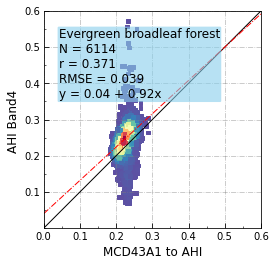

In [316]:
# XX = np.array(XX).reshape(-1) * 0.972 + 0.001

# XX = np.array(XX).reshape(-1) * 0.983
# XX = np.array(XX).reshape(-1) * 0.981 + 0.001 # Open S
YY = np.array(X_Fitting_B4[1,12:24,25:75,25:75]).reshape(-1)
XX = np.array(MODIS_2_AHI_cm[12:24,:,:]).reshape(-1) * 1.014
# XX = np.array(XX_B3).reshape(-1) * 0.975 + 0.00027
# XX = np.array(XX_B1).reshape(-1) * 1.008 - 0.002
# XX = np.array(XX_B2).reshape(-1) * 0.827 + 0.01
# XX = np.array(XX_B5).reshape(-1) * 0.955 + 0.00034


nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]


nan_mask = ~np.isnan(XX.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]
XX = identifer(XX)
YY = identifer(YY)
rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

pccs = np.corrcoef(XX, YY)[0,1]
pccs = round(pccs.astype('float64'),3)

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')
ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=2,direction='in',labelsize=10)
ax1.tick_params(axis="y",which='major',length=5,direction='in',labelsize=10)

ax1.tick_params(axis="x",which='minor',length=2,direction='in',labelsize=10)
ax1.tick_params(axis="x",which='major',length=5,direction='in',labelsize=10)


# ax1.spines['right'].set_color('none')
# ax1.spines['top'].set_color('none')


im = ax1.scatter(XX,YY,marker='s', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_ylabel("AHI Band4 ",fontsize=12)
ax1.set_xlabel("MCD43A1 to AHI",fontsize=12)


ax1.plot(x,y,color='k',linewidth=1,linestyle='-',alpha=1)
ax1.plot(xx,yy,color='r',linewidth=1,linestyle='-.') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.4

ax1.text(text_x,text_y,s = 'Evergreen broadleaf forest\nN = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),pccs,rmse,b,k),fontsize=12,bbox=dict(boxstyle='round,pad=0.1', fc='skyblue', ec='none',lw=2 ,alpha=0.6))

# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
# plt.title('2018/07/26')
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)
plt.grid(color='gray',alpha=0.5,linestyle='-.')
# fig.savefig('{}_{}_{}_B{}.jpg'.format(i_idx,j_idx,MM,str(i+1)),dpi = 1000,bbox_inches = 'tight')
plt.show()

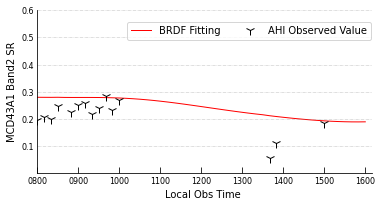

In [317]:
k,m = 35,60
d = 1
r = 50

fig,axes = plt.subplots(1,1,figsize=(6, 3))
axes.tick_params(axis="y",which='major',length=0,direction='in',labelsize=8)
axes.tick_params(axis="x",which='major',length=6,direction='in',labelsize=8)

axes.spines['right'].set_color('none')
axes.spines['top'].set_color('none') 


# X = X_Fitting[i].reshape(total_day,49,2*r,2*r)[:,:,:,:]
# Y1 = Y_Fitting[i].reshape(total_day,49,2*r,2*r)[:,:,:,:]
# Y2 = Y_MaxMin[i].reshape(total_day,49,2*r,2*r)[:,:,:,:]

# nan_mask = ~np.isnan(X.reshape(-1))
# X1 = X.reshape(-1)[nan_mask]
# Y1 = Y1.reshape(-1)[nan_mask]
# nan_mask = ~np.isnan(Y1.reshape(-1))
# X1 = X1.reshape(-1)[nan_mask]
# Y1 = Y1.reshape(-1)[nan_mask]

# nan_mask = ~np.isnan(X.reshape(-1))
# X2 = X.reshape(-1)[nan_mask]
# Y2 = Y2.reshape(-1)[nan_mask]
# nan_mask = ~np.isnan(Y2.reshape(-1))
# X2 = X2.reshape(-1)[nan_mask]
# Y2 = Y2.reshape(-1)[nan_mask]

# axis_min = 0
# axis_max = np.nanmax(np.nanmax(Y1)) * 2


# rmse_fitting = np.sqrt(mean_squared_error(X1 ,Y1))
# r2_fitting = r2_score(X1,Y1)
# rmse_MaxMin = np.sqrt(mean_squared_error(X2 ,Y2))
# r2_MaxMin = r2_score(X2,Y2)

# rmse_fitting = round(rmse_fitting.astype('float64'),3)
# r2_fitting = round(r2_fitting.astype('float64'),3)
# rmse_MaxMin = round(rmse_MaxMin.astype('float64'),3)
# r2_MaxMin = round(r2_MaxMin.astype('float64'),3)

axes.plot(label,MODIS_2_AHI.reshape(49,2*25,2*25)[:,10,35],c='red',marker="o",markersize=0,linewidth=1,label='BRDF Fitting',zorder=0)        
axes.plot(label,X_Fitting_B4.reshape(5,49,2*r,2*r)[d,:,35,60],c='k',marker="1",markersize=10,linewidth=0,label='AHI Observed Value',zorder=2)

# for k in range (40,60):
#     for m in range (40,60):
#         axes.plot(label,MODIS_2_AHI.reshape(49,2*r,2*r)[:,k,m],c='red',marker="o",markersize=0,linewidth=1,label='BRDF Fitting',zorder=0)        
#         axes.plot(label,X_Fitting_B4.reshape(5,49,2*r,2*r)[d,:,k,m],c='k',marker="1",markersize=10,linewidth=0,label='Observed Value',zorder=2)

axes.set_xticks(np.arange(0,49,6))
axes.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

axes.set_xlabel("Local Obs Time ",fontsize=10)
axes.set_ylabel("MCD43A1 Band2 SR",fontsize=10)

fig.legend(bbox_to_anchor=(0.91, 0.85),ncol=3)
text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22
axes.grid(color='gray', axis='y',linestyle='-.', linewidth=0.5,alpha=0.5)
axes.set_xlim(axis_min,49)
axes.set_ylim(axis_min,axis_max)
# axes.set_title('({})'.format(chr(ord('a')+(i*2)+j)),loc='left',y=0.85,x=-0.1)
# axes.text(1,axis_max *0.75,s = 'RMSE = {}\nR2 = {}'.\
#                format(rmse_fitting,r2_fitting),fontsize=15,bbox=dict(boxstyle='round,pad=0.1', fc='red', ec='none',lw=2 ,alpha=0.3))
# axes.text(1,axis_max*0.7,s = 'Pre :RMSE = {}  R2 = {}'.\
#                format(rmse_MaxMin,r2_MaxMin),fontsize=12,bbox=dict(boxstyle='round,pad=0.1', fc='darkgreen', ec='none',lw=2 ,alpha=0.3))

# fig.savefig('{}_{}_{}_B{}_BRDF_Performance.jpg'.format(i_idx,j_idx,MM,str(i+1)),dpi = 1000,bbox_inches = 'tight')
plt.show()

# MOD09

In [ ]:
def lonlat2tileidx(latlon:tuple)->tuple:
    # vertical pixel count in one tile, horizontal pixel count in one tile
    lintile, coltile = 1200, 1200
    # vertical tile count, horizontal tile count
    vtilenum, htilenum = 18, 36
    # [deg/pixel]
    d = 180.0/lintile/vtilenum
    # from S-pole to N-pole
    NL = 180.0/d
    NP0 = 2*np.round(180.0/d)
    res1 = (90 - latlon[0])/d-0.5
    V_idx = res1 // lintile
    # Y_idx = res1 - V_idx * lintile
    # GCOM-C use integer NPi
    NPi = (NP0*np.cos(np.deg2rad(latlon[0])))
    # NPi = round(NP0*np.cos(np.deg2rad(latlon[0])))
    res2 = latlon[1]*NPi/360 - 0.5 + NP0/2
    H_idx = res2 // coltile
    # X_idx = res2 - H_idx * coltile
    return round(V_idx),round(H_idx)



In [239]:
Band = ["SensorZenith_1","SensorAzimuth_1","SolarZenith_1","SolarAzimuth_1","sur_refl_b01_1","sur_refl_b02_1","sur_refl_b03_1","sur_refl_b04_1","sur_refl_b05_1","sur_refl_b06_1","sur_refl_b07_1" ]
date = '20180122'
with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_SolarZenith_1.dat'.format(date),'rb') as fp:
    MOD09GA_SZA = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.01
    
with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_SolarAzimuth_1.dat'.format(date),'rb') as fp:
    MOD09GA_SAA = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.01
    
with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_SensorZenith_1.dat'.format(date),'rb') as fp:
    MOD09GA_VZA = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.01

with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_SensorAzimuth_1.dat'.format(date),'rb') as fp:
    MOD09GA_VAA = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.01
    
r = 25

MOD09GA_SZA = np.where(MOD09GA_SZA==3.2767,np.nan,MOD09GA_SZA)
MOD09GA_SAA = np.where(MOD09GA_SAA==3.2767,np.nan,MOD09GA_SAA)
MOD09GA_VZA = np.where(MOD09GA_VZA==3.2767,np.nan,MOD09GA_VZA)
MOD09GA_VAA = np.where(MOD09GA_VAA==3.2767,np.nan,MOD09GA_VAA)

MOD09GA_SAA = np.where(MOD09GA_SAA<0,360+MOD09GA_SAA,MOD09GA_SAA)
MOD09GA_VAA = np.where(MOD09GA_VAA<0,360+MOD09GA_VAA,MOD09GA_VAA)

MOD09GA_SZA = MOD09GA_SZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
MOD09GA_SAA = MOD09GA_SAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
MOD09GA_VZA = MOD09GA_VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
MOD09GA_VAA = MOD09GA_VAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

In [264]:
# date = '201801211'

with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_sur_refl_b01_1.dat'.format(date),'rb') as fp:
    MOD09GA_Band1 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.0001     
r = 50

MOD09GA_Band1 = np.where(MOD09GA_Band1==3.2767,np.nan,MOD09GA_Band1)
MOD09GA_Band1 = MOD09GA_Band1[i_idx-r:i_idx+r,j_idx-r:j_idx+r]


In [240]:
# date = '20180121'

with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_sur_refl_b02_1.dat'.format(date),'rb') as fp:
    MOD09GA_Band2 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.0001     
r = 25

MOD09GA_Band2 = np.where(MOD09GA_Band2==3.2767,np.nan,MOD09GA_Band2)
MOD09GA_Band2 = MOD09GA_Band2[i_idx-r:i_idx+r,j_idx-r:j_idx+r]


In [270]:
# date = '201801211'

with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_sur_refl_b03_1.dat'.format(date),'rb') as fp:
    MOD09GA_Band3 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.0001     
r = 50

MOD09GA_Band3 = np.where(MOD09GA_Band3==3.2767,np.nan,MOD09GA_Band3)
MOD09GA_Band3 = MOD09GA_Band3[i_idx-r:i_idx+r,j_idx-r:j_idx+r]


In [273]:
# date = '201801211'

with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_sur_refl_b04_1.dat'.format(date),'rb') as fp:
    MOD09GA_Band4 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.0001     
r = 50

MOD09GA_Band4 = np.where(MOD09GA_Band4==3.2767,np.nan,MOD09GA_Band4)
MOD09GA_Band4 = MOD09GA_Band4[i_idx-r:i_idx+r,j_idx-r:j_idx+r]


In [276]:
# date = '201801211'

with open('/data01/people/liwei/Data/MCD43A4_AHI/MOD09GA_{}_sur_refl_b06_1.dat'.format(date),'rb') as fp:
    MOD09GA_Band6 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.0001     
r = 50

MOD09GA_Band6 = np.where(MOD09GA_Band6==3.2767,np.nan,MOD09GA_Band6)
MOD09GA_Band6 = MOD09GA_Band6[i_idx-r:i_idx+r,j_idx-r:j_idx+r]


In [237]:
MOD09 = []
MOD09GA_VAA = []
MOD09GA_SAA = []
MOD09GA_SZA = []
MOD09GA_VZA = []


AHI_lat = np.linspace(60,-59.99,12000)[i_idx-r:i_idx+r]
AHI_lon = np.linspace(85,204.99,12000)[j_idx-r:j_idx+r]
for i in range(100):
    for j in range(100):
        V,H = lonlat2tileidx([AHI_lat[i],AHI_lon[j]])
        # print(V,H)
        geotiff_da = rioxarray.open_rasterio('/data01/people/liwei/Data/HEG_Reslt/MOD09GA.A2018021.h{}v{}.061.B2.tif'.format(H,V))
        data = geotiff_da.interp(x=AHI_lon[j],y=AHI_lat[i],method="nearest")
        if data != -32768.:
            data = data * 0.0001 
            MOD09.append(data)
        else:
            MOD09.append(np.nan)
            
        geotiff_da = rioxarray.open_rasterio('/data01/people/liwei/Data/HEG_Reslt/MOD09GA.A2018021.h{}v{}.061.SZA.tif'.format(H,V))
        data = geotiff_da.interp(x=AHI_lon[j],y=AHI_lat[i],method="nearest")
        if data != -32768.:
            data = data * 0.01 
            MOD09GA_SZA.append(data)
        else:
            MOD09GA_SZA.append(np.nan) 
            
        geotiff_da = rioxarray.open_rasterio('/data01/people/liwei/Data/HEG_Reslt/MOD09GA.A2018021.h{}v{}.061.VZA.tif'.format(H,V))
        data = geotiff_da.interp(x=AHI_lon[j],y=AHI_lat[i],method="nearest")
        if data != -32768.:
            data = data * 0.01 
            MOD09GA_VZA.append(data)
        else:
            MOD09GA_VZA.append(np.nan)   
            
        geotiff_da = rioxarray.open_rasterio('/data01/people/liwei/Data/HEG_Reslt/MOD09GA.A2018021.h{}v{}.061.VAA.tif'.format(H,V))
        data = geotiff_da.interp(x=AHI_lon[j],y=AHI_lat[i],method="nearest")
        if data != -32768.:
            data = data * 0.01 
            MOD09GA_VAA.append(data)
        else:
            MOD09GA_VAA.append(np.nan)
            
            
        geotiff_da = rioxarray.open_rasterio('/data01/people/liwei/Data/HEG_Reslt/MOD09GA.A2018021.h{}v{}.061.SAA.tif'.format(H,V))
        data = geotiff_da.interp(x=AHI_lon[j],y=AHI_lat[i],method="nearest")
        if data != -32768.:
            data = data * 0.01 
            MOD09GA_SAA.append(data)
        else:
            MOD09GA_SAA.append(np.nan)
            
MOD09 = np.array(MOD09).reshape(100,100)
MOD09GA_VAA = np.array(MOD09GA_VAA).reshape(100,100)
MOD09GA_SAA = np.array(MOD09GA_SAA).reshape(100,100)
MOD09GA_SZA = np.array(MOD09GA_SZA).reshape(100,100)
MOD09GA_VZA = np.array(MOD09GA_VZA).reshape(100,100)



In [241]:
MOD09GA_RAA = abs(MOD09GA_VAA - MOD09GA_SAA)
MOD09GA_RAA = np.where(MOD09GA_RAA>180,360-MOD09GA_RAA,MOD09GA_RAA)

In [242]:
MOD09GA_kvol = RTK(MOD09GA_SZA,MOD09GA_VZA,MOD09GA_RAA).reshape(2*r,2*r)
MOD09GA_kgeo = LSR_MaxMin(MOD09GA_SZA,MOD09GA_VZA,MOD09GA_RAA).reshape(2*r,2*r)

# XX_B1 = MOD09GA_Band3
# YY_B1 = fiso_fitting_B1 + MOD09GA_kvol*fvol_fitting_B1 + MOD09GA_kgeo*fgeo_fitting_B1

# XX_B2 = MOD09GA_Band4
# YY_B2 = fiso_fitting_B2 + MOD09GA_kvol*fvol_fitting_B2 + MOD09GA_kgeo*fgeo_fitting_B2

# XX_B3 = MOD09GA_Band1
# YY_B3 = fiso_fitting_B3 + MOD09GA_kvol*fvol_fitting_B3 + MOD09GA_kgeo*fgeo_fitting_B3

XX_B4 = MOD09GA_Band2
YY_B4 = fiso_fitting_B4[25:75,25:75] + MOD09GA_kvol*fvol_fitting_B4[25:75,25:75] + MOD09GA_kgeo*fgeo_fitting_B4[25:75,25:75]

# XX_B5 = MOD09GA_Band6
# YY_B5 = fiso_fitting_B5 + MOD09GA_kvol*fvol_fitting_B5 + MOD09GA_kgeo*fgeo_fitting_B5


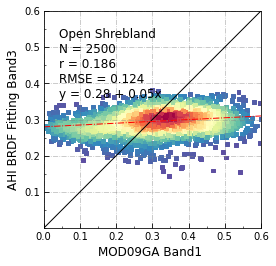

In [243]:
YY = np.array(YY_B4).reshape(-1)
XX = np.array(XX_B4).reshape(-1) * 1.014
# XX = np.array(XX_B3).reshape(-1) * 0.975 + 0.00027
# XX = np.array(XX_B1).reshape(-1) * 1.008 - 0.002
# XX = np.array(XX_B2).reshape(-1) * 0.827 + 0.01
# XX = np.array(XX_B5).reshape(-1) * 0.955 + 0.00034


nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]


nan_mask = ~np.isnan(XX.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]
XX = identifer(XX)
YY = identifer(YY)
rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

pccs = np.corrcoef(XX, YY)[0,1]
pccs = round(pccs.astype('float64'),3)

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')
ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=2,direction='in',labelsize=10)
ax1.tick_params(axis="y",which='major',length=5,direction='in',labelsize=10)

ax1.tick_params(axis="x",which='minor',length=2,direction='in',labelsize=10)
ax1.tick_params(axis="x",which='major',length=5,direction='in',labelsize=10)


# ax1.spines['right'].set_color('none')
# ax1.spines['top'].set_color('none')


im = ax1.scatter(XX,YY,marker='s', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("MOD09GA Band1 ",fontsize=12)
ax1.set_ylabel("AHI BRDF Fitting Band3",fontsize=12)


ax1.plot(x,y,color='k',linewidth=1,linestyle='-',alpha=1)
ax1.plot(xx,yy,color='r',linewidth=1,linestyle='-.') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.4

ax1.text(text_x,text_y,s = 'Open Shrebland\nN = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),pccs,rmse,b,k),fontsize=12)

# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
# plt.title('2018/07/26')
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)
plt.grid(color='gray',alpha=0.5,linestyle='-.')
# fig.savefig('{}_{}_{}_B{}.jpg'.format(i_idx,j_idx,MM,str(i+1)),dpi = 1000,bbox_inches = 'tight')
plt.show()

# AHI SZA/SAA

In [573]:
# 南半球
i_idx,j_idx = 8000,4500 # 25 Open Shrubland 01/21～26

i_idx,j_idx = 8698,4470 # 35 Open Shrubland 01/02~06 21～26 07/01~05
i_idx,j_idx = 8400,4000 # 35 Open Shrubland 01/02~06 07/01~05
i_idx,j_idx = 9100,5500 # 35 Open Shrubland 01/02~06 07/01~05

i_idx,j_idx = 9300,3400 # 45 Grassland  and Cropland  01/21～26


i_idx,j_idx = 1645,3931 # 55

In [ ]:
1645,3931

In [578]:
VZA[1645,3931]

52.86

In [609]:
i_idx,j_idx = 9300,3400 # 45 Grassland  and Cropland  01/21～26
AHI_SZA_45_Summer = np.array([])
AHI_SAA_45_Summer = np.array([])
AHI_RAA_45_Summer = np.array([])

d_count = 1
for d in range(21,26):
    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])
    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)
        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_45_Summer = np.append(AHI_SZA_45_Summer,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_45_Summer = np.append(AHI_SAA_45_Summer,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_45_Summer = np.append(AHI_RAA_45_Summer,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1

    
AHI_SZA_45_Winter = np.array([])
AHI_SAA_45_Winter = np.array([])
AHI_RAA_45_Winter = np.array([])

d_count = 1

for d in range(1,6):
    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])

    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)

        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_45_Winter = np.append(AHI_SZA_45_Winter,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_45_Winter = np.append(AHI_SAA_45_Winter,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_45_Winter = np.append(AHI_RAA_45_Winter,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1  

21
22
23
24
25
1
2
3
4
5


In [610]:
i_idx,j_idx = 8698,4470 # 35 Open Shrubland 01/02~06 21～26 07/01~05
AHI_SZA_35_Summer = np.array([])
AHI_SAA_35_Summer = np.array([])
AHI_RAA_35_Summer = np.array([])

d_count = 1
for d in range(21,26):
    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])
    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)
        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_35_Summer = np.append(AHI_SZA_35_Summer,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_35_Summer = np.append(AHI_SAA_35_Summer,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_35_Summer = np.append(AHI_RAA_35_Summer,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1

    
AHI_SZA_35_Winter = np.array([])
AHI_SAA_35_Winter = np.array([])
AHI_RAA_35_Winter = np.array([])

d_count = 1

for d in range(1,6):
    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])

    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)

        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_35_Winter = np.append(AHI_SZA_35_Winter,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_35_Winter = np.append(AHI_SAA_35_Winter,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_35_Winter = np.append(AHI_RAA_35_Winter,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1  

21
22
23
24
25
1
2
3
4
5


In [611]:
i_idx,j_idx = 8000,4500 # 25 Open Shrubland 01/21～26

AHI_SZA_25_Summer = np.array([])
AHI_SAA_25_Summer = np.array([])
AHI_RAA_25_Summer = np.array([])

d_count = 1
for d in range(21,26):
    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])
    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)
        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_25_Summer = np.append(AHI_SZA_25_Summer,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_25_Summer = np.append(AHI_SAA_25_Summer,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_25_Summer = np.append(AHI_RAA_25_Summer,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1

    
AHI_SZA_25_Winter = np.array([])
AHI_SAA_25_Winter = np.array([])
AHI_RAA_25_Winter = np.array([])

d_count = 1

for d in range(1,6):
    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])

    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)

        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_25_Winter = np.append(AHI_SZA_25_Winter,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_25_Winter = np.append(AHI_SAA_25_Winter,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_25_Winter = np.append(AHI_RAA_25_Winter,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1  

21
22
23
24
25
1
2
3
4
5


In [1508]:
i_idx,j_idx = 1628,3059 # 55
AHI_SZA_55_Summer = np.array([])
AHI_SAA_55_Summer = np.array([])
AHI_RAA_55_Summer = np.array([])

d_count = 1
for d in range(1,6):
    date_start = '2018-07-{} 00:00'.format(str(d))
    date_end = '2018-07-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])
    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)
        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_55_Summer = np.append(AHI_SZA_55_Summer,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_55_Summer = np.append(AHI_SAA_55_Summer,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_55_Summer = np.append(AHI_RAA_55_Summer,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1

    
AHI_SZA_55_Winter = np.array([])
AHI_SAA_55_Winter = np.array([])
AHI_RAA_55_Winter = np.array([])

d_count = 1

for d in range(21,26):
    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    AHI_SZA_day = np.array([])
    AHI_SAA_day = np.array([])
    AHI_RAA_day = np.array([])

    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx,j_idx]
        SZA_1 = SZA[i_idx,j_idx]
        SAA_1 = SAA[i_idx,j_idx]
        del SZA,SAA,RAA
        AHI_SZA_day = np.append(AHI_SZA_day,SZA_1).reshape(count,1)
        AHI_SAA_day = np.append(AHI_SAA_day,SAA_1).reshape(count,1)
        AHI_RAA_day = np.append(AHI_RAA_day,RAA_1).reshape(count,1)

        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
    AHI_SZA_55_Winter = np.append(AHI_SZA_55_Winter,AHI_SZA_day).reshape(d_count,54,1)
    AHI_SAA_55_Winter = np.append(AHI_SAA_55_Winter,AHI_SAA_day).reshape(d_count,54,1)
    AHI_RAA_55_Winter = np.append(AHI_RAA_55_Winter,AHI_RAA_day).reshape(d_count,54,1)
    d_count += 1  

1
2
3
4
5
21
22
23
24
25


In [ ]:
SGLI_SAA_pixel = []
SGLI_SZA_pixel = []
SGLI_VAA_pixel = []
SGLI_VZA_pixel = []

for i in range(7):
    if SGLI_SAA[i].size != 0:
        SGLI_SAA_pixel.append(SGLI_SAA[i].reshape(10,10)[5,5])
        SGLI_SZA_pixel.append(SGLI_SZA[i].reshape(10,10)[5,5])
        SGLI_VAA_pixel.append(SGLI_VAA[i].reshape(10,10)[5,5])
        SGLI_VZA_pixel.append(SGLI_VZA[i].reshape(10,10)[5,5])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

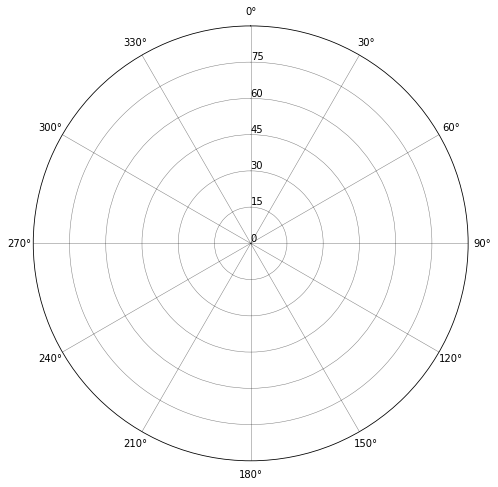

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 15))
ax.set_rlabel_position(0.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
ax.set_axisbelow('True')
# plt.scatter(np.radians(np.array(SAA_valid)[:,i_idx,j_idx]),np.array(SZA_valid)[:,i_idx,j_idx], c='none', marker='o', edgecolors='r', s=40)
plt.scatter(np.radians(np.array(AHI_SAA)[:,i_idx,j_idx]),np.array(AHI_SZA)[:,i_idx,j_idx], c='g', marker='o', s=40)
plt.scatter(np.radians(VAA[1400:1900,5450:6150][i_idx,j_idx]),VZA[i_idx,j_idx], c='blue', marker='o', s=40)

plt.scatter(np.radians(np.array(SGLI_SAA_pixel)),np.array(SGLI_SZA_pixel), c='none', marker='o', edgecolors='k', s=40)
plt.scatter(np.radians(np.array(SGLI_VAA_pixel)),np.array(SGLI_VZA_pixel), c='none', marker='o', edgecolors='r', s=40)

            
plt.show()

In [418]:

_RAA_Input = [(AHI_RAA_25_Summer,AHI_RAA_25_Winter),(AHI_RAA_35_Summer,AHI_RAA_35_Winter),(AHI_RAA_45_Summer,AHI_RAA_45_Winter),(AHI_RAA_55_Summer,AHI_RAA_55_Winter)]
_SZA_Input = [(AHI_SZA_25_Summer,AHI_SZA_25_Winter),(AHI_SZA_35_Summer,AHI_SZA_35_Winter),(AHI_SZA_45_Summer,AHI_SZA_45_Winter),(AHI_SZA_55_Summer,AHI_SZA_55_Winter)]
sub_title = ['20.1°S,130.1°E','26.98°S,129.7°E','32.9°S,119.2°E','43.55°N,124.31°E']

        axes[i,j].scatter(np.radians(_RAA_Input[(i*2)+j][0]),_SZA_Input[(i*2)+j][0].reshape(-1), marker='o',c='none',edgecolors='r',lw=0.4,label='Summer')
        axes[i,j].scatter(np.radians(_RAA_Input[(i*2)+j][1]),_SZA_Input[(i*2)+j][1].reshape(-1), marker='o',c='none',edgecolors='b',lw=0.4,label='Winter')
        
# cbar_ax = fig.add_axes() 
# plt.colorbar(sc, cax=cbar_ax)
# fig.colorbar(im, ax=[axes[0,0],axes[0,1], axes[1,0],axes[1,1]], fraction=0.025, pad=0.04)
cbar = fig.colorbar(im, ax=axes,fraction=0.03)
lines, labels = axes[1,1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(0.58, 0.18),ncol=2)

plt.show()

37.28

In [ ]:
_SAA_Input = [(AHI_SAA_25_Summer,AHI_SAA_25_Winter),(AHI_SAA_35_Summer,AHI_SAA_35_Winter),(AHISAA_45_Summer,AHI_SAA_45_Winter),(AHI_SAA_55_Summer,AHI_SAA_55_Winter)]
_SZA_Input = [(AHI_SZA_25_Summer,AHI_SZA_25_Winter),(AHI_SZA_35_Summer,AHI_SZA_35_Winter),(AHI_SZA_45_Summer,AHI_SZA_45_Winter),(AHI_SZA_55_Summer,AHI_SZA_55_Winter)]
fig,axes = plt.subplots(2,2,figsize=(11, 11),subplot_kw=dict(projection="polar"))
for i in range(2):
    for j in range(2):
        re = []
        for k in range(180):
            c = LSR(sza_test,vza_test[(i*2)+j],raa_test[k])
            re.append(c)
        axes[i,j].set_theta_offset(0)
        #设置极坐标系的起始角度为90°
        axes[i,j].set_theta_direction(1)
        axes[i,j].set_thetagrids(np.arange(0.0, 361.0, 30.0))
        axes[i,j].set_thetamin(0.0)  
        axes[i,j].set_thetamax(360.0)
        axes[i,j].set_rgrids(np.arange(0, 81, 20))
        axes[i,j].set_rlabel_position(np.pi/2)
        axes[i,j].set_rlim(0, 80)
        axes[i,j].set_yticklabels(['0°', '20°', '40°', '60°', '80°'])
        # ax.set_axisbelow('True')
        axes[i,j].pcolormesh(np.radians(theta),r,np.array(re),edgecolors='face',cmap='jet')
        axes[i,j].grid(linestyle="-", color="k", linewidth=0.8,alpha=0.8)
        axes[i,j].set_title('({}) {} '.format(chr(ord('a')+(i*2)+j),sub_title[(i*2)+j]),loc='left',y=0.85)
        axes[i,j].scatter(np.radians(_SAA_Input[(i*2)+j][0]),_SZA_Input[(i*2)+j][0].reshape(-1), marker='o',c='none',edgecolors='r',lw=0.4,label='Summer')
        axes[i,j].scatter(np.radians(_SAA_Input[(i*2)+j][1]),_SZA_Input[(i*2)+j][1].reshape(-1), marker='o',c='none',edgecolors='b',lw=0.4,label='Winter')

# ALBEDO

In [ ]:
def R(vza,raa):
    cos_xi = np.cos(np.radians(sza)) * np.cos(np.radians(vza)) + np.sin(np.radians(sza)) * np.sin(np.radians(vza))* np.cos(np.radians(raa))
    xi = np.arccos(cos_xi)
    rtk = (((np.pi/2 - xi) * cos_xi + np.sin(xi)) / (np.cos(np.radians(sza)) + np.cos(np.radians(vza)))) - np.pi/4


    
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsr = O - sec__sza - sec__vza + 0.5 * (1 + cos__xi) * sec__sza * sec__vza
    
    
    
    return (fi + fg*lsr + fv*rtk) * cos_vza * sin_vza / np.pi


In [ ]:
fi = fiso[5,5]
fg = fgeo[5,5]
fv = fvol[5,5]

In [ ]:
from scipy import integrate
v, err = integrate.dblquad(R,0, np.pi/2,0,2*np.pi)

<ipython-input-1446-6e951a8ab1ab>:36: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


In [ ]:
v

nan

In [ ]:
BSA = []
for sza in range(0,80):
    print(sza)
    v, err = integrate.dblquad(R,0, np.pi/2,0,2*np.pi)
    BSA.append(v)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


<ipython-input-1440-9e97b4602cfe>:36: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


(0.0, 0.6)

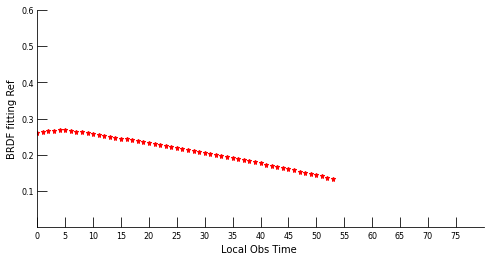

In [ ]:
axis_min = 0
axis_max = 0.6

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

ax1.plot(np.arange(0,80,1),np.array(BSA),color = 'r',marker="*",markersize=5,linewidth=0,label='{},{}'.format(i,j))

ax1.set_xticks(np.arange(0,80,5))
ax1.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)



text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.set_xlim(axis_min,80)
ax1.set_ylim(axis_min,axis_max)
# plt.legend()